In [3]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'
os.environ['OMP_NUM_THREADS'] = '16'
os.environ['OPENBLAS_VERBOSE'] = '2'
os.environ['OMP_DISPLAY_ENV'] ='VERBOSE'

import pyvista as pv
pv.start_xvfb()

import dolfinx
import dolfinx.fem.petsc

from OpInf import *
import numpy as np
import sys
import scipy
import h5py
import tqdm
import json

import torch
import adios4dolfinx
import dolfinx
import cProfile
import pstats
import io
import mpi4py
import numpy as np
import h5py
from scipy import linalg
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
from dolfinx import fem, mesh, io, plot

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from itertools import product, combinations

from sklearn.manifold import SpectralEmbedding

from pathlib import Path
import json
import stiefel
import pickle as pkl
from stiefel import *
import importlib

importlib.reload(stiefel)

import importlib

importlib.reload(stiefel)

from scipy.io import loadmat
from operators import ckron, ckron_indices

import scienceplots

plt.style.use(["science", "grid"])
plt.rcParams.update({"font.size": 20})

# set numpy random seed
np.random.seed(3)


# %%
from Representation import *

from basix.ufl import element
from dolfinx.fem import (
    Constant,
    Function,
    functionspace,
    assemble_scalar,
    dirichletbc,
    form,
    locate_dofs_topological,
    set_bc,
    Expression,
)

from dolfinx.io import VTXWriter, distribute_entity_data, gmshio

pv.set_plot_theme('document')
pv.global_theme.font.size = 20
pv.global_theme.font.family = 'times'
pv.global_theme.font.title_size = 20
pv.global_theme.font.label_size = 20
pv.global_theme.font.color = 'black'

Core: Cooperlake

OPENMP DISPLAY ENVIRONMENT BEGIN
  _OPENMP = '201511'
  OMP_DYNAMIC = 'FALSE'
  OMP_NESTED = 'FALSE'
  OMP_NUM_THREADS = '16'
  OMP_SCHEDULE = 'DYNAMIC'
  OMP_PROC_BIND = 'FALSE'
  OMP_PLACES = ''
  OMP_STACKSIZE = '93920636971522'
  OMP_WAIT_POLICY = 'PASSIVE'
  OMP_THREAD_LIMIT = '4294967295'
  OMP_MAX_ACTIVE_LEVELS = '2147483647'
  OMP_CANCELLATION = 'FALSE'
  OMP_DEFAULT_DEVICE = '0'
  OMP_MAX_TASK_PRIORITY = '0'
  GOMP_CPU_AFFINITY = ''
  GOMP_STACKSIZE = '93920636971522'
  GOMP_SPINCOUNT = '300000'
OPENMP DISPLAY ENVIRONMENT END

OPENMP DISPLAY ENVIRONMENT BEGIN
   _OPENMP='201611'
  [host] KMP_ABORT_DELAY='0'
  [host] KMP_ADAPTIVE_LOCK_PROPS='1,1024'
  [host] KMP_ALIGN_ALLOC='64'
  [host] KMP_ALL_THREADPRIVATE='128'
  [host] KMP_ATOMIC_MODE='2'
  [host] KMP_BLOCKTIME='200ms
  [host] KMP_CPUINFO_FILE: value is not defined
  [host] KMP_DETERMINISTIC_REDUCTION='FALSE'
  [host] KMP_DEVICE_THREAD_LIMIT='2147483647'
  [host] KMP_DISP_NUM_BUFFERS='7'
  [host] KMP_DUPL

check syl solve
True
here
True
6.6272653879146e-14
Use algebraic Stiefel log, metric alpha =  -0.0
dist 3.76991118430775
NORM TEST1: 0.0
NORM TEST2: 3.596220543577999e-13
NORM TEST3: 7.217317021801506e-15


In [4]:
# mus = [1.1, 1.05, 1, 0.95, 0.9]
# mus = [1.15, 1.1, 1.05, 1, 0.95, 0.9, 0.85]
# mus = [0.4, 0.6, 0.8, 1.0, 1.2]
mus = [
    0.002000,
    0.001333,
    0.001000,
    #    -----
    0.001111,
    #    -----
    0.000909,
    #    -----
    0.000800,
    0.000667,
    0.000571,
    0.000500,
]

Reynolds = [75, 112.5, 135, 150, 165, 187.5, 225, 262.5, 300]

mus_reynolds_dict = { mu: Re for mu, Re in zip(mus, Reynolds) }

# Load data
t_start = 4
T_end_train = 5

variable = "u"

# Load the HDF5 file
combined_dataseet_filepath = Path(
    f"/data1/jy384/research/Data/UnimodalSROB/ns/{variable}_combined_dataset.h5"
)

with h5py.File(combined_dataseet_filepath, "r") as f:
    mus = f.attrs["mu_values"]
    U_c = f.attrs["U_c"]
    L_c = f.attrs["L_c"]
    rho = f.attrs["rho"]

    # Get the shape of the data
    sample_group = f[f"mu_{mus[0]:.6f}"]
    data_shape = sample_group["snapshots"].shape


test_mu = 0.000556
test_Re = int(np.round(1.5 * 0.1 * 1 / test_mu))
X_all_test = np.load(
    f"/data1/jy384/research/Data/UnimodalSROB/ns/Re_{test_Re}_mu_{test_mu}/{variable}_snapshots_matrix_test.npy"
).T


import yaml
from omegaconf import OmegaConf

base_path = Path("/data1/jy384/research/Data/UnimodalSROB/ns/")
effective_dts = {}

for i, mu in enumerate(mus):
    Re = Reynolds[i]
        
    
    # Calculate Re based on U_c, L_c, rho, and mu
    folder_name = f"Re_{Re}_mu_{mu:.6f}"
    metadata_path = base_path / folder_name / f"{variable}_snapshots_matrix_train_metadata.yaml"

    print("Metadata path: ", metadata_path)

    if metadata_path.exists():
        with open(metadata_path, "r") as f:
            config_dict = yaml.safe_load(f)

        cfg = OmegaConf.create(config_dict)
        effective_dts[mu] = cfg.effective_dt
    else:
        print(f"Metadata file not found for mu = {mu}")

for mu, dt in effective_dts.items():
    print(f"For mu = {mu:.6f}, effective dt = {dt}")


p = 2
Mp = len(mus)

dt = effective_dts[mus[0]]

config = {
    "N": data_shape[0],
    "dt": 1e-3,
    "T_end": T_end_train,
    "mus": list(mus),
    "Mp": Mp,
    "K": T_end_train / dt,  # T_end / dt
    "DS": 1,
    "params": {
        "modelform": "LQCP",
        "modeltime": "continuous",
        "dt": dt,
        "ddt_order": "4c",
        "p": p,  # polynomial order
        "lambda1": 5e-2,
        "lambda2": 5e-2,
        "lambda3": 100,
    },
    "type": "single",
}


# %%
# a colors list to tag the group of combinations
colors = plt.get_cmap("tab20").colors

# Create a dictionary to store combinations with their respective colors
tagged_combinations = {}

for r in range(1, len(mus) - 1):
    combinations_ = list(combinations(mus[1:-1], r))
    combinations_ = [(mus[0],) + combo + (mus[-1],) for combo in combinations_]
    print(f"{len(combinations_)} of combinations generated: ", combinations_)

    # Ensure that there are enough colors, cycle through colors if necessary
    color = colors[(r - 1) % len(colors)]

    # Store the combinations with their tag
    tagged_combinations[color] = combinations_

# Flatten the list and maintain the color tagging
flattened_tagged_combinations = [
    (item, color) for color, combos in tagged_combinations.items() for item in combos
]

# Example of accessing the flattened list with color tags
for combo, color in flattened_tagged_combinations:
    print(f"Combination: {combo}, Color: {color}")

# randomly draw 3 ICs (mus) without replacement from X_all_nominal
drawn_mus = [tup[0] for tup in flattened_tagged_combinations]
color_tags = []
for n_X in range(len(flattened_tagged_combinations)):
    mus_list = mus.tolist()
    mus_idx = [mus_list.index(mus_) for mus_ in flattened_tagged_combinations[n_X][0]]
    # print(mus_idx)
    color_tags.append(flattened_tagged_combinations[n_X][1])

# X_list.append(X_nominal)
# color_tags.append((0,1,1)) # cyan

rob_lst = []
rel_err_SVD_lst = []
idx_lst = []
# names = [f"tap={taps}" for taps in numtaps] + ["Nominal"]

names = []
for mus in drawn_mus:
    mus_frac = []
    for mu in mus:
        # print(1/10 * np.round(1 / mu))
        mus_frac.append(f"0.15/{mus_reynolds_dict[mu]}")
    
    names.append(f"$\mu$={tuple(mus_frac)}")

# names = [f"$\mu$={mus}" for mus in drawn_mus]

print(names)

err_tol = 5e-2


# %%
# Model parameters
r = 3  # min for 5e-2
q_trunc = 13
# p = 3

tol = 1e-3  # tolerence for alternating minimization
gamma = 0.01  # regularization parameter\
max_iter = 100  # maximum number of iterations

import os

basis_operators_file = base_path / f"{variable}_basis_operators_mu_{test_mu:.6f}.hdf5"
print("Checking if file at", basis_operators_file, "exists")
if basis_operators_file.exists():
    print("Loading operators from file")
    with h5py.File(basis_operators_file, "r") as f:
        # check if number of operators is the same as number of combos
        if len(f["operators_lst"]) != len(drawn_mus):
            raise ValueError(
                f"Number of operators in file {basis_operators_file} is not the same as number of combos"
            )
        operators_lst = []

        Vr_lst = f["Vr_lst"][:]
        Vbar_lst = f["Vbar_lst"][:]

        # Load operators_lst
        operators_lst = []
        operators_grp = f["operators_lst"]
        for i in range(len(operators_grp)):
            ops = {}
            combo_grp = operators_grp[f"combo_{i}"]
            for key in combo_grp.keys():
                ops[key] = combo_grp[key][:]
            operators_lst.append(ops)

        print("Loaded basis and operators data")

        # Now you can use Vr_lst, Vbar_lst, and operators_lst in your code
        print(f"Number of Vr matrices: {len(Vr_lst)}")
        print(f"Number of Vbar matrices: {len(Vbar_lst)}")
        print(f"Number of operator sets: {len(operators_lst)}")


# Aligning the signs of Vr_lst with Vr_lst[-1]
Vr1 = Vr_lst[-1]
for idx in range(len(Vr_lst) - 1):
    Vr_idx = Vr_lst[idx]
    for j in range(Vr_idx.shape[1]):
        dist1 = np.linalg.norm(Vr1[:, j] - Vr_idx[:, j])
        dist2 = np.linalg.norm(Vr1[:, j] + Vr_idx[:, j])
        if dist2 < dist1:
            Vr_lst[idx][:, j] = -Vr_lst[idx][:, j]


# For Vbar_lst, ensuring sign agreement with Vbar_lst[-1]
Vbar1 = Vbar_lst[-1]
for idx in range(len(Vbar_lst) - 1):
    Vbar_idx = Vbar_lst[idx]
    for j in range(Vbar_idx.shape[1]):
        dist1 = np.linalg.norm(Vbar1[:, j] - Vbar_idx[:, j])
        dist2 = np.linalg.norm(Vbar1[:, j] + Vbar_idx[:, j])
        if dist2 < dist1:
            Vbar_lst[idx][:, j] = -Vbar_lst[idx][:, j]

V_combined_lst = [
    np.concatenate([Vr, Vbar], axis=1) for Vr, Vbar in zip(Vr_lst, Vbar_lst)
]

# plot spectral embedding of the generated stiefel sampels
flat_Vr_arr = np.concatenate([rob.flatten()[:, None] for rob in Vr_lst], axis=1)
flat_Vbar_arr = np.concatenate([rob.flatten()[:, None] for rob in Vbar_lst], axis=1)
flat_V_combined_arr = np.concatenate(
    [rob.flatten()[:, None] for rob in V_combined_lst], axis=1
)

# colors =
colors = plt.cm.tab20c(np.linspace(0, 1, len(Vr_lst)))


# Perform spectral embedding
embedder = SpectralEmbedding(n_components=2)
embedding_Vr = embedder.fit_transform(flat_Vr_arr.T)
embedding_Vbar = embedder.fit_transform(flat_Vbar_arr.T)

T_end_index = int((T_end_train - t_start) / dt)

Metadata path:  /data1/jy384/research/Data/UnimodalSROB/ns/Re_75_mu_0.002000/u_snapshots_matrix_train_metadata.yaml
Metadata path:  /data1/jy384/research/Data/UnimodalSROB/ns/Re_112.5_mu_0.001333/u_snapshots_matrix_train_metadata.yaml
Metadata path:  /data1/jy384/research/Data/UnimodalSROB/ns/Re_135_mu_0.001111/u_snapshots_matrix_train_metadata.yaml
Metadata path:  /data1/jy384/research/Data/UnimodalSROB/ns/Re_150_mu_0.001000/u_snapshots_matrix_train_metadata.yaml
Metadata path:  /data1/jy384/research/Data/UnimodalSROB/ns/Re_165_mu_0.000909/u_snapshots_matrix_train_metadata.yaml
Metadata path:  /data1/jy384/research/Data/UnimodalSROB/ns/Re_187.5_mu_0.000800/u_snapshots_matrix_train_metadata.yaml
Metadata path:  /data1/jy384/research/Data/UnimodalSROB/ns/Re_225_mu_0.000667/u_snapshots_matrix_train_metadata.yaml
Metadata path:  /data1/jy384/research/Data/UnimodalSROB/ns/Re_262.5_mu_0.000571/u_snapshots_matrix_train_metadata.yaml
Metadata path:  /data1/jy384/research/Data/UnimodalSROB/ns/

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.colors import to_rgba, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from matplotlib.cm import ScalarMappable

def plot_svd_decay_with_groups(rel_err_SVD_lst, drawn_mus):
    """
    Plot SVD decay with horizontal colorbars showing transparency gradients.
    """
    # Create figure with main plot and space for colorbars
    fig = plt.figure(figsize=(10, 8))
    gs = plt.GridSpec(2, 1, height_ratios=[3, 2])
    ax_main = fig.add_subplot(gs[0])
    ax_guide = fig.add_subplot(gs[1])
    
    # Create color scheme for different combination sizes
    n_groups = len(set(len(mu) for mu in drawn_mus))
    base_colors = plt.cm.Set1(range(n_groups))
    
    # Create a mapping of combination size to color and prepare group information
    color_map = {}
    group_info = {}
    for i, size in enumerate(sorted(set(len(mu) for mu in drawn_mus))):
        color_map[size] = base_colors[i]
        group_info[size] = {
            'color': base_colors[i],
            'count': len([mu for mu in drawn_mus if len(mu) == size])
        }
    
    # Plot SVD decay curves
    for i, mus in enumerate(drawn_mus):
        rel_err_SVD = rel_err_SVD_lst[i]
        base_color = color_map[len(mus)]
        same_size_combinations = [mu for mu in drawn_mus if len(mu) == len(mus)]
        alpha = 0.9 - (0.5 * same_size_combinations.index(mus) / len(same_size_combinations))
        
        color_with_alpha = to_rgba(base_color, alpha)
        ax_main.plot(rel_err_SVD, color=color_with_alpha, linewidth=1)
    
    # Customize main plot
    ax_main.set_yscale('log')
    ax_main.set_ylabel("Error ε(r)")
    ax_main.grid(True, alpha=0.2)
    ax_main.set_xlabel("Rank r")
    
    max_size = max(group_info.keys())
    
    # Create group-level legend
    legend_elements = []
    for size, info in group_info.items():
        legend_elements.append(
            Rectangle((0, 0), 1, 1, facecolor=info['color'],
                     label=f'$^{max_size}C_{size}$ (n={info["count"]})')
        )
        
    ax_main.legend(handles=legend_elements, 
                  title="Color Guide",
                  loc='center left', 
                  bbox_to_anchor=(1.05, 0.5))
    
    # Create horizontal colorbars
    ax_guide.set_title("Combination index (high → low transparency)", pad=10, fontsize=16)
    
    # Calculate positions for colorbars
    n_groups = len(group_info)
    bar_height = 0.2 / n_groups
    
    # Remove existing axes
    ax_guide.set_frame_on(False)
    ax_guide.set_xticks([])
    ax_guide.set_yticks([])
    
    for i, (size, info) in enumerate(sorted(group_info.items(), reverse=True)):
        # Create colormap that goes from high to low alpha
        base_color = info['color']
        
        # Create colormap - single color for n=1, gradient otherwise
        colors = [to_rgba(base_color[:3], 0.9)] * 2 if info['count'] == 1 else [to_rgba(base_color[:3], alpha) for alpha in [0.9, 0.4]]
        cmap = LinearSegmentedColormap.from_list(f'custom_{size}', colors)
        
        # Create axes for this colorbar
        cax_pos = [0.15, 0.125 + i * bar_height, 0.7, bar_height * 0.7]  # [left, bottom, width, height]
        cax = fig.add_axes(cax_pos)
        
        # Create colorbar
        norm = plt.Normalize(0, 1)
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, cax=cax, orientation='horizontal', ticks=[])
        
        # Add labels
        cax.text(-0.025, 0.5, f"$^{max_size}C_{size}$",
                ha='right', va='center', transform=cax.transAxes, fontsize=12)
        cax.text(1.025, 0.5, f"(n={info['count']})", 
                ha='left', va='center', transform=cax.transAxes, fontsize=12)
    
    # Create a new axis for First/Last labels at the bottom
    # Adjusted position: moved lower by increasing the negative offset
    label_ax_pos = [0.15, 0.125 - 1.5 * bar_height, 0.7, bar_height * 0.5]  # Increased negative offset
    label_ax = fig.add_axes(label_ax_pos)
    label_ax.set_frame_on(False)
    label_ax.set_xticks([])
    label_ax.set_yticks([])
    
    # Add First/Last labels with adjusted vertical position
    label_ax.text(0, 0.5, 'First', ha='left', va='center', fontsize=12)
    label_ax.text(1, 0.5, 'Last', ha='right', va='center', fontsize=12)
    
    plt.tight_layout()
    return fig

0it [00:00, ?it/s]

127it [00:00, 162.63it/s]


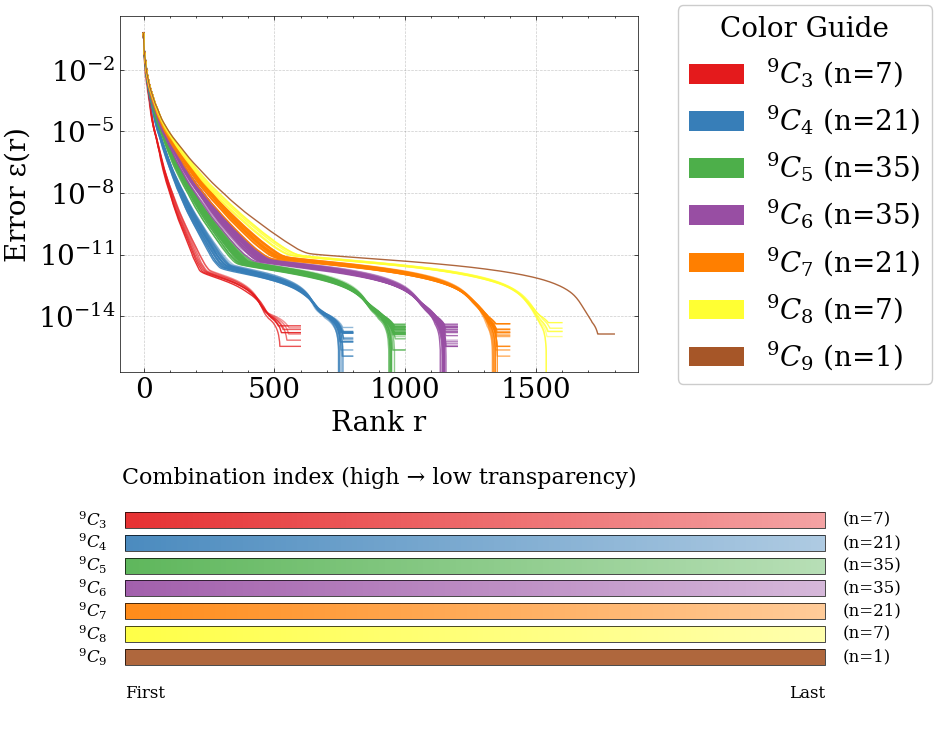

In [6]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
# svd_results_file = Path(
#     f"/data1/jy384/research/Data/UnimodalSROB/ns/{variable}_svd_results.h5"
# )
# rel_err_SVD_lst = []
# with h5py.File(svd_results_file, "r") as f:
#     for i, combo in tqdm.tqdm(enumerate(drawn_mus)):
#         results = f[f"combo_{i}"]
#         S = results["S"][:]
        
#         eigvals_SVD = S ** 2 * (1 / (len(S) - 1))
#         rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
#         rel_err_SVD_lst.append(rel_err_SVD)

#         ax.plot(rel_err_SVD_lst[i], linestyle='-', alpha=0.7)
#         ax.set_yscale('log')
        
#         ax.grid(True, alpha=0.2)
        
# ax.set_ylabel("Error $\\epsilon(r)$")
# ax.set_xlabel("Rank r")

# plt.savefig("errorFunc_all_NS.pdf", bbox_inches='tight')

# turn off latex
plt.rc('text', usetex=False)
svd_results_file = Path(
    f"/data1/jy384/research/Data/UnimodalSROB/ns/{variable}_svd_results.h5"
)
rel_err_SVD_lst = []
with h5py.File(svd_results_file, "r") as f:
    for i, combo in tqdm.tqdm(enumerate(drawn_mus)):
        results = f[f"combo_{i}"]
        S = results["S"][:]
        
        eigvals_SVD = S ** 2 * (1 / (len(S) - 1))
        rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
        rel_err_SVD_lst.append(rel_err_SVD)

#         ax.plot(rel_err_SVD_lst[i], linestyle='-', alpha=0.7)
#         ax.set_yscale('log')
        
#         ax.grid(True, alpha=0.2)
        
# ax.set_ylabel("Error $\\epsilon(r)$")
# ax.set_xlabel("Rank r")

# plt.savefig("errorFunc_all_NS.pdf", bbox_inches='tight')

fig = plot_svd_decay_with_groups(rel_err_SVD_lst, drawn_mus)
plt.savefig("errorFunc_all_NS.pdf", bbox_inches='tight')

In [4]:
# read mesh
def print_mesh_info(mesh: dolfinx.mesh.Mesh):
    cell_map = mesh.topology.index_map(mesh.topology.dim)
    node_map = mesh.geometry.index_map()
    print(
        f"Rank {mesh.comm.rank}: number of owned cells {cell_map.size_local}",
        f", number of ghosted cells {cell_map.num_ghosts}\n",
        f"Number of owned nodes {node_map.size_local}",
        f", number of ghosted nodes {node_map.num_ghosts}",
    )


def read_mesh(filename: Path):
    from mpi4py import MPI

    import dolfinx

    import adios4dolfinx

    mesh = adios4dolfinx.read_mesh(
        filename,
        comm=MPI.COMM_WORLD,
        engine="BP4",
        ghost_mode=dolfinx.mesh.GhostMode.none,
    )
    print_mesh_info(mesh)

    return mesh

In [5]:
import mpi4py
base_path = Path("/data1/jy384/research/Data/UnimodalSROB/ns/")
mesh_path = base_path / f"Re_{test_Re}_mu_{test_mu}" / f"{variable}_snapshots_mu{test_mu}.bp"
mymesh = read_mesh(mesh_path)

Rank 0: number of owned cells 10584 , number of ghosted cells 0
 Number of owned nodes 42904 , number of ghosted nodes 0


In [6]:
grid = pv.UnstructuredGrid(*plot.vtk_mesh(mymesh))

In [7]:
def pairwise_mat_distances(matrices, norm_function):
    num_matrices = len(matrices)
    
    # Initialize a 2D array with zeros
    pair_dist = np.zeros((num_matrices, num_matrices))
    
    for i in range(num_matrices):
        for j in range(i+1, num_matrices):
            matrix_a = matrices[i]
            matrix_b = matrices[j]
            norm_diff = norm_function(matrix_a, matrix_b)
            # Store the norm difference in the pair_dist array
            pair_dist[i][j] = norm_diff
            pair_dist[j][i] = norm_diff  # Since distance is symmetric
            
    
    # normalize the distance matrix
    max_val = np.max(pair_dist)
    min_val = np.min(pair_dist)
    pair_dist = (pair_dist - min_val) / (max_val - min_val)
    return pair_dist

def frobenius_norm_difference(matrix_a, matrix_b):
    norm_a = np.linalg.norm(matrix_a, "fro")
    norm_b = np.linalg.norm(matrix_b, "fro")
    diff_norm = np.linalg.norm(matrix_a - matrix_b, "fro")
    return diff_norm

In [8]:
# # calculate the normalized frobenius norm difference between the V_combined basis 
# V_combined_frobenius = pairwise_mat_distances(V_combined_lst, frobenius_norm_difference)

# # plot the spectral embedding of the V_combined basis colored by the normalized frobenius norm difference
# V_combined_embedding = embedder.fit_transform(flat_V_combined_arr.T)

# fig, ax = plt.subplots(figsize=(8, 6))
# scatter = ax.scatter(V_combined_embedding[:, 0], V_combined_embedding[:, 1], c=V_combined_frobenius.sum(axis=1), cmap='viridis')
# cbar = fig.colorbar(scatter, ax=ax)
# cbar.set_label('Sum of Pairwise Frobenius Distances')
# # ax.set_title('Spectral Embedding of V_combined Basis Colored by Sum of Pairwise Frobenius Distances')
# ax.set_title('Spectral Embedding of $[V]$')
# plt.show()

In [9]:
with open(base_path / f"{variable}_representatives_data_KMeans.pkl", "rb") as f:
    representatives_data = pkl.load(f)
    
representatives = representatives_data["indices"]
n_clusters = representatives_data["n_clusters"]
cluster_labels = representatives_data["cluster_labels"]

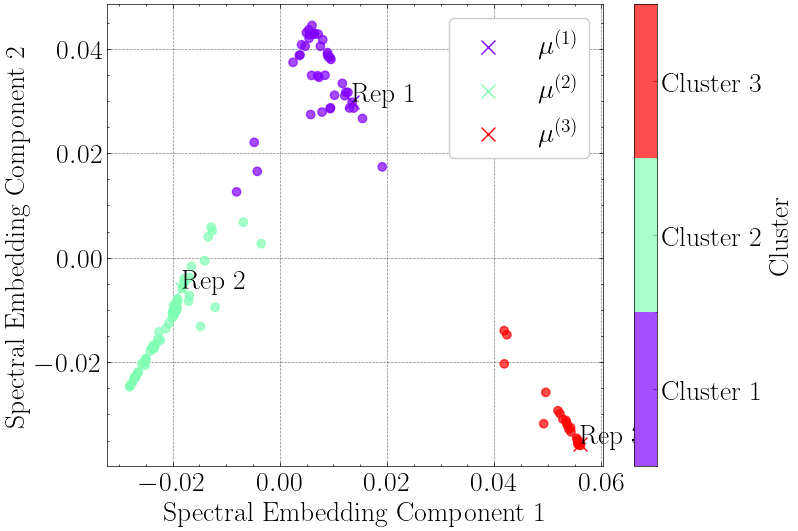

In [10]:
from matplotlib.colors import BoundaryNorm

# plot the spectral embedding of the V_combined basis colored by the normalized frobenius norm difference
V_combined_embedding = embedder.fit_transform(flat_V_combined_arr.T)

optimal_n_clusters = np.unique(cluster_labels).shape[0]

# Create a colormap with the same number of colors as clusters
cmap = plt.get_cmap('rainbow', optimal_n_clusters)

# Define the boundaries for the discrete color intervals
boundaries = np.arange(optimal_n_clusters + 1) - 0.5
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(V_combined_embedding[:, 0], V_combined_embedding[:, 1], c=cluster_labels, cmap=cmap, norm=norm, alpha=0.7)

# Create a discrete colorbar
cbar = fig.colorbar(scatter, ax=ax, boundaries=boundaries, ticks=np.arange(optimal_n_clusters))
cbar.set_label('Cluster')

# Set the tick labels for the colorbar
cbar.set_ticklabels([f'Cluster {i+1}' for i in range(optimal_n_clusters)])

# ax.set_title('Spectral Embedding of $[V]$')
texts = []
for i, rep in enumerate(representatives):
    # ax.scatter(V_combined_embedding[rep, 0], V_combined_embedding[rep, 1], c='black', marker='x', s=100)
    ax.scatter(V_combined_embedding[rep, 0], V_combined_embedding[rep, 1], c=cluster_labels[rep], cmap=cmap, norm=norm, s=100, marker='x', label=r"$\mu^{(" + f"{i+1}" + ")}$")
    text = ax.annotate(f"Rep {i+1}", (V_combined_embedding[rep, 0], V_combined_embedding[rep, 1]))
    texts.append(text)

# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
ax.legend()
ax.set_xlabel('Spectral Embedding Component 1')
ax.set_ylabel('Spectral Embedding Component 2')
plt.savefig("SE_V_basis_KMeans_Cluster_NS_r3.pdf", bbox_inches='tight')

plt.show()

In [11]:
def compute_magnitude(s_rec):
    """
    Compute the magnitude of the reconstructed state.

    :param s_rec: Reconstructed state array of shape (15168, 800)
    :return: Magnitude array of shape (7584, 800)
    """
    # interleaved u and v components
    component_len = s_rec.shape[0] // 2
    u = s_rec[0::2, :]
    v = s_rec[1::2, :]

    # Compute magnitude
    magnitude = np.sqrt(u**2 + v**2)

    return magnitude

In [12]:
X_list_sel = []
with h5py.File(combined_dataseet_filepath, "r") as file:
    for i, index in tqdm.tqdm(enumerate(representatives)):
        # i = i_ + 11
        X = []
        combo = drawn_mus[index]
        for mu in combo:
            grp = file[f"mu_{mu:.6f}"]
            snapshot = grp["snapshots"][:]
            X.append(snapshot)
        
        X = np.concatenate(X, axis=1)
    
        X_list_sel.append(X)

3it [00:13,  4.49s/it]


In [13]:
X_all_global = np.concatenate(X_list_sel, axis=1)
X_all_global = X_all_global - np.mean(X_all_global, axis=1)[:, None]

In [14]:
drawn_mus[representatives[i]]

(0.002, 0.0008, 0.000667, 0.0005)

In [15]:
# names_sel = [names[i] for i in representatives]
names_sel = []

for i in range(len(representatives)):
    
    names = []
    for mu in drawn_mus[representatives[i]]:
        # print(1/10 * np.round(1 / mu))
        mus_frac.append(f"0.15/{mus_reynolds_dict[mu]}")
            
    names_sel.append(r"$\mu^{(" + f"{i+1}" + ")}$" + f"={tuple(mus_frac)}")
    
names_sel.append("Global")

In [16]:
np.linalg.cond(X_all_global)

9.701056773904908e+35

In [17]:
# V_combined_global = np.linalg.svd(X_all_global, full_matrices=False)[0][
#     :, : r + q_trunc
# ]
V_combined_global = torch.linalg.svd(
        torch.tensor(X_all_global, device="cuda"),
        driver="gesvda",
        full_matrices=False,
    )[0][
    :, : r + q_trunc
].cpu().numpy()



V_combined1 = V_combined_global
Vr1 = V_combined1[:, :r]
Vbar1 = V_combined1[:, r:]

for idx in range(len(Vr_lst)):
    Vr_idx = Vr_lst[idx]
    Vbar_idx = Vbar_lst[idx]

    for j in range(Vr_idx.shape[1]):
        dist1 = np.linalg.norm(Vr1[:, j] - Vr_idx[:, j])
        dist2 = np.linalg.norm(Vr1[:, j] + Vr_idx[:, j])
        if dist2 < dist1:
            Vr_lst[idx][:, j] = -Vr_lst[idx][:, j]

    for j in range(Vbar_idx.shape[1]):
        dist1 = np.linalg.norm(Vbar1[:, j] - Vbar_idx[:, j])
        dist2 = np.linalg.norm(Vbar1[:, j] + Vbar_idx[:, j])
        if dist2 < dist1:
            Vbar_lst[idx][:, j] = -Vbar_lst[idx][:, j]

    for j in range(V_combined1.shape[1]):
        dist1 = np.linalg.norm(V_combined1[:, j] - V_combined_lst[idx][:, j])
        dist2 = np.linalg.norm(V_combined1[:, j] + V_combined_lst[idx][:, j])
        if dist2 < dist1:
            V_combined_lst[idx][:, j] = -V_combined_lst[idx][:, j]

Vr_lst_sel = []
Vbar_lst_sel = []
V_combined_lst_stochastic = []

for i in representatives:
    V_combined_lst_stochastic.append(V_combined_lst[i])
    Vr_lst_sel.append(Vr_lst[i])
    Vbar_lst_sel.append(Vbar_lst[i])

V_combined_lst_stochastic.append(V_combined_global)
Vr_lst_sel.append(V_combined_global[:, :r])
Vbar_lst_sel.append(V_combined_global[:, r:])

assert np.allclose(V_combined_lst_stochastic[0][:, :r], Vr_lst_sel[0])

3it [00:05,  1.87s/it]


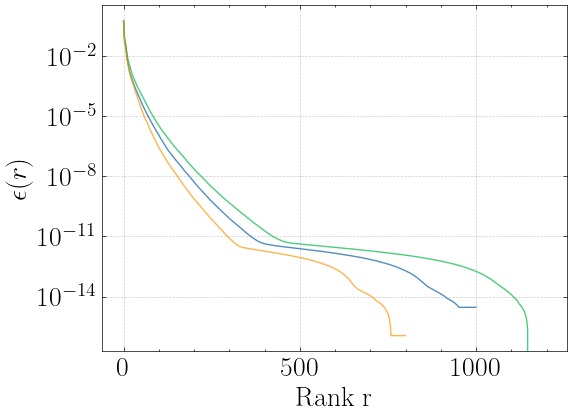

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
rel_err_SVD_lst_sel = []

for i, index in tqdm.tqdm(enumerate(representatives)):
    X = X_list_sel[i]
    X_ref = np.mean(X, axis=1)[:, None]
    X_centered = X - X_ref

    U, S, Vt = torch.linalg.svd(
        torch.tensor(X_centered, device="cuda"),
        driver="gesvda",
        full_matrices=False,
    )
    
    eigvals_SVD = S.cpu().numpy() ** 2 * (1 / (len(S) - 1))
    rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
    rel_err_SVD_lst_sel.append(rel_err_SVD)
    
    ax.plot(rel_err_SVD_lst_sel[i], label=names_sel[i], linestyle='-', alpha=0.7)
    ax.set_yscale('log')
    ax.set_ylabel("$\\epsilon(r)$")
    ax.grid(True, alpha=0.2)
    ax.set_xlabel("Rank r")

S = torch.linalg.svdvals(
        torch.tensor(X_all_global, device="cuda"),
        driver="gesvda",
    )
eigvals_SVD = S.cpu().numpy() ** 2 * (1 / (len(S) - 1))
rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
rel_err_SVD_lst_sel.append(rel_err_SVD)

3it [00:00, 2467.24it/s]


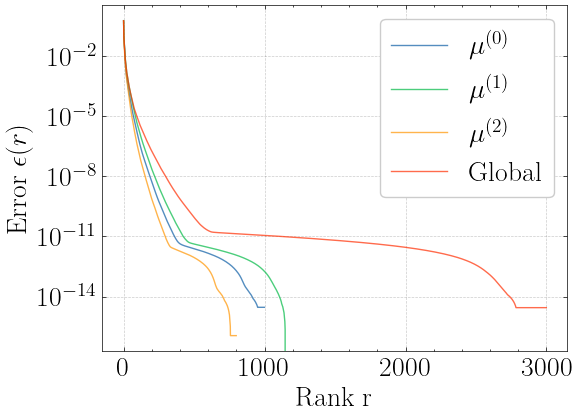

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
for i, index in tqdm.tqdm(enumerate(representatives)):
    ax.plot(rel_err_SVD_lst_sel[i], label=r"$\mu^{(" + f"{i}" + ")}$", linestyle='-', alpha=0.7)
    ax.set_yscale('log')
    ax.set_ylabel("$\\epsilon(r)$")
    ax.grid(True, alpha=0.2)
    ax.set_xlabel("Rank r")

ax.plot(rel_err_SVD_lst_sel[-1], label="Global", linestyle='-', alpha=0.7)
ax.set_yscale('log')
ax.set_ylabel("Error $\\epsilon(r)$")
ax.grid(True, alpha=0.2)
ax.set_xlabel("Rank r")
ax.legend()

plt.savefig("errorFunc_Global_NS_r3.pdf", bbox_inches="tight")

In [20]:
s_rec_full_file = base_path / f"{variable}_s_rec_full_mu_{test_mu:.6f}_KMeans.h5"
with h5py.File(s_rec_full_file, "r") as s_rec_file:
    # Load a specific combo's s_rec_full
    combo_index = representatives[0]  # or any other index
    s_rec_full_0 = s_rec_file[f"combo_{combo_index}"][:]

    # Or load all combos
    # all_s_rec_full = {key: s_rec_file[key][:] for key in s_rec_file.keys()}

print("Loaded s_rec_full data")

Loaded s_rec_full data


In [21]:
s_rec_full_0 = compute_magnitude(s_rec_full_0)

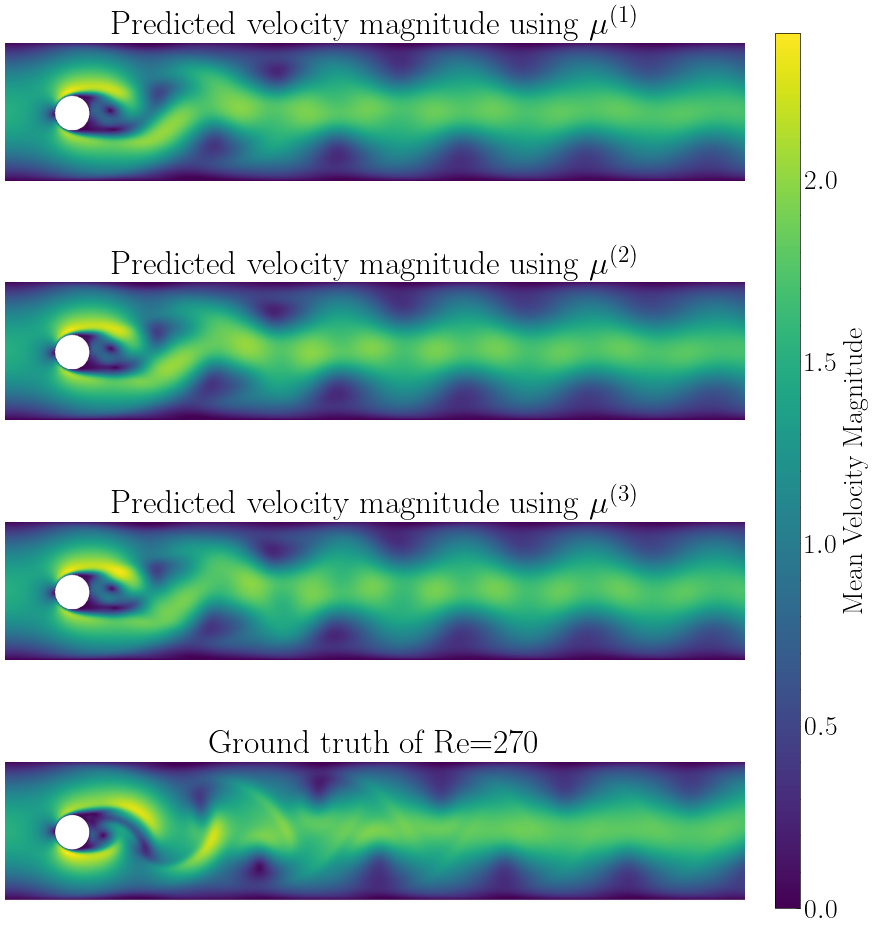

In [22]:
# Set up matplotlib figure
from matplotlib import ticker
fig, axes = plt.subplots(4, 1, figsize=(10, 10))

with h5py.File(s_rec_full_file, "r") as s_rec_file:
    for i, index in enumerate(representatives):
        # Create a PyVista plotter for this subplot
        plotter = pv.Plotter(off_screen=True)
        
        # Load and process data
        s_rec_full = s_rec_file[f"combo_{index}"][:]
        s_rec_full_mag = compute_magnitude(s_rec_full)
        
        # Set up the PyVista plot
        grid.point_data["Velocity Magnitude"] = s_rec_full_mag[:, T_end_index]
        grid.set_active_scalars("Velocity Magnitude")
        plotter.add_mesh(grid, show_edges=False, show_scalar_bar=False, lighting=False, clim=[0, 2.4])
        plotter.view_xy()
        plotter.camera.tight()
        
        # Capture the PyVista plot as an image
        image = plotter.screenshot(transparent_background=True)
        
        # Display the image in the matplotlib subplot
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(r"Predicted velocity magnitude using $\mu^{(" + f"{i+1}" + ")}$")
        
        # Clear the plotter to free up memory
        plotter.clear()

# Create a PyVista plotter for this subplot
plotter = pv.Plotter(off_screen=True)
X_all_test_mag = compute_magnitude(X_all_test)
# Set up the PyVista plot
grid.point_data["Velocity Magnitude"] = X_all_test_mag[:, T_end_index]
grid.set_active_scalars("Velocity Magnitude")
plotter.add_mesh(grid, show_edges=False, show_scalar_bar=False, lighting=False)
plotter.view_xy()
plotter.camera.tight()

# Capture the PyVista plot as an image
image = plotter.screenshot(transparent_background=True, scale=3)

# Display the image in the matplotlib subplot
axes[-1].imshow(image)
axes[-1].axis('off')  # Turn off axis
axes[-1].set_title(f"Ground truth of Re={test_Re}")

plotter.clear()



cax = fig.add_axes([0.8, 0.05, 0.025, 0.875], aspect="auto")
cbar = plt.colorbar(ScalarMappable(cmap="viridis", norm=Normalize(vmin=0, vmax=2.4)),
                            cax=cax, orientation="vertical")
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label("Mean Velocity Magnitude")

plt.tight_layout(rect=[0, 0, 0.8, 1])
# plt.suptitle(f"Reconstructed velocity magnitude at t = {T_end_train}s")
# plt.savefig(f"{variable}_s_rec_full_operator_compare.png", dpi=300, bbox_inches='tight')
plt.savefig(f"soln_comb_selected_operators_velocity_mag.pdf", bbox_inches='tight')
plt.show()

In [23]:
N_stiefel_samples = 1000

U0 = V_combined_lst_stochastic[-1]

try:
    stiefel_samples_file = base_path / f"{variable}_stiefel_samples_combined_KMeans.h5"
    if stiefel_samples_file.exists():
        print("Stiefel samples file found. Loading samples.")
        with h5py.File(stiefel_samples_file, "r") as stiefel_file:
            stiefel_samples_combined = stiefel_file["stiefel_samples"][:]
            maxI = stiefel_file["maxI"][:]
            beta = stiefel_file["beta"][:]
            
    else:
        raise FileNotFoundError
    
    print("Stiefel samples loaded successfully.")
    print("Stiefel samples shape:", stiefel_samples_combined.shape)
    print("MaxI shape:", maxI.shape)
    print("Beta paramters: ", beta)
    
    
except FileNotFoundError:
    print("Stiefel samples file not found. Generating new samples.")
    stiefel_samples_combined, maxI, beta = stiefel.gen_stiefel_samples(
        N_stiefel_samples, V_combined_lst_stochastic, tau=0.00001, metric_alpha=0.0000000000
    )

    # Align signs of stiefel samples with global ROB
    for i in range(len(stiefel_samples_combined)):
        for j in range(stiefel_samples_combined[i].shape[1]):
            dist1 = np.linalg.norm(U0[:, j] - stiefel_samples_combined[i][:, j])
            dist2 = np.linalg.norm(U0[:, j] + stiefel_samples_combined[i][:, j])
            if dist2 < dist1:
                stiefel_samples_combined[i][:, j] = -stiefel_samples_combined[i][:, j]

    # stiefel_samples_Vr = np.array([sample[:, :r] for sample in stiefel_samples_combined])
    # stiefel_samples_Vbar = np.array(
    #     [sample[:, r : r + q_trunc] for sample in stiefel_samples_combined]
    # )
    
    # save the 1000 stiefel_samples_combined to a file
    stiefel_samples_file = base_path / f'{variable}_stiefel_samples_combined_KMeans.h5'
    with h5py.File(stiefel_samples_file, 'w') as f:
        f.create_dataset('stiefel_samples', data=stiefel_samples_combined)
        f.create_dataset('maxI', data=maxI)
        f.create_dataset('beta', data=beta)

Stiefel samples file found. Loading samples.


Stiefel samples loaded successfully.
Stiefel samples shape: (1000, 85808, 16)
MaxI shape: (1000,)
Beta paramters:  [0.49668607 0.35914051 0.14417342]


In [24]:
# append the frechet_mean to the dataset
try:
    stiefel_samples_file = base_path / f"{variable}_stiefel_samples_combined_KMeans.h5"
    if stiefel_samples_file.exists():
        print("stiefel_samples_file already exists")
        print("Loading Frechet mean from file")
        with h5py.File(stiefel_samples_file, 'r') as f:
            frechet_mean = f['frechet_mean'][:]
            Vr_frechet_mean = f['Vr_frechet_mean'][:]
            Vbar_frechet_mean = f['Vbar_frechet_mean'][:]
    
    else:
        raise FileNotFoundError
except:
    frechet_mean = calc_frechet_mean_mat(
    stiefel_samples_combined, V_combined_lst_stochastic[-1], eps=1e-2, tau=1e-3
    )[0]
    Vr_frechet_mean = frechet_mean[:, :r]
    Vbar_frechet_mean = frechet_mean[:, r : +r + q_trunc]
    with h5py.File(stiefel_samples_file, 'a') as f:
        f.create_dataset('frechet_mean', data=frechet_mean)
        f.create_dataset('Vr_frechet_mean', data=Vr_frechet_mean)
        f.create_dataset('Vbar_frechet_mean', data=Vbar_frechet_mean)

stiefel_samples_file already exists
Loading Frechet mean from file


In [25]:
import sys
from IPython import get_ipython
import numpy as np

def sizeof_fmt(num, suffix='B'):
    for unit in ['','K','M','G','T','P','E','Z']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Y', suffix)

def get_variable_size(var):
    if isinstance(var, np.ndarray):
        return var.nbytes
    try:
        return sys.getsizeof(var)
    except TypeError:
        return 0  # Return 0 for objects that don't support getsizeof

# Get a copy of the variables dictionary
variables = dict(get_ipython().user_ns)
var_sizes = {}

for name, value in variables.items():
    if not name.startswith('_') and not callable(value):
        try:
            size = get_variable_size(value)
            if isinstance(size, (int, float)):  # Only store numeric sizes
                var_sizes[name] = size
        except:
            pass

# Sort variables by size in descending order
sorted_vars = sorted(var_sizes.items(), key=lambda x: x[1], reverse=True)

# Print variables and their sizes
print("Variable sizes:")
for name, size in sorted_vars:
    print(f"{name}: {sizeof_fmt(size)} ({size / (1024**3):.6f} GB)")

# Calculate and print total size
total_size = sum(var_sizes.values())
print(f"\nTotal size of all variables: {sizeof_fmt(total_size)} ({total_size / (1024**3):.6f} GB)")

Variable sizes:
stiefel_samples_combined: 10.2GB (10.229111 GB)
X_all_global: 1.9GB (1.917958 GB)
flat_V_combined_arr: 1.3GB (1.299097 GB)
Vbar_lst: 1.1GB (1.055516 GB)
flat_Vbar_arr: 1.1GB (1.055516 GB)
X_all_test: 523.7MB (0.511456 GB)
X: 523.7MB (0.511456 GB)
X_centered: 523.7MB (0.511456 GB)
s_rec_full: 261.9MB (0.255728 GB)
X_all_test_mag: 261.9MB (0.255728 GB)
Vr_lst: 249.4MB (0.243581 GB)
flat_Vr_arr: 249.4MB (0.243581 GB)
snapshot: 130.9MB (0.127864 GB)
s_rec_full_0: 130.9MB (0.127864 GB)
s_rec_full_mag: 130.9MB (0.127864 GB)
V_combined_global: 10.5MB (0.010229 GB)
V_combined1: 10.5MB (0.010229 GB)
U0: 10.5MB (0.010229 GB)
frechet_mean: 10.5MB (0.010229 GB)
Vbar1: 8.5MB (0.008311 GB)
Vbar_idx: 8.5MB (0.008311 GB)
Vbar_frechet_mean: 8.5MB (0.008311 GB)
image: 6.7MB (0.006557 GB)
Vr1: 2.0MB (0.001918 GB)
Vr_idx: 2.0MB (0.001918 GB)
Vr_frechet_mean: 2.0MB (0.001918 GB)
X_ref: 670.4KB (0.000639 GB)
eigvals_SVD: 23.4KB (0.000022 GB)
rel_err_SVD: 23.4KB (0.000022 GB)
maxI: 7.8KB (0.0

# Adjust basis for spectral embedding

In [26]:
# %%
# plot spectral embedding of the generated stiefel sampels
flat_Vr_arr = np.concatenate([rob.flatten()[:, None] for rob in Vr_lst_sel], axis=1)
flat_Vbar_arr = np.concatenate([rob.flatten()[:, None] for rob in Vbar_lst_sel], axis=1)
flat_V_combined_arr_stochastic = np.concatenate(
    [rob.flatten()[:, None] for rob in V_combined_lst_stochastic], axis=1
)
flat_Vr_frechet_mean = Vr_frechet_mean.flatten()[:, None]
flat_Vbar_frechet_mean = Vbar_frechet_mean.flatten()[:, None]
rob_Vr_all = np.concatenate(
    # [rob[:, :r].flatten()[:, None] for rob in stiefel_samples_Vr]
    [rob[:, :r].flatten()[:, None] for rob in stiefel_samples_combined]
    + [flat_Vr_arr]
    + [flat_Vr_frechet_mean],
    axis=1,
)
rob_Vbar_all = np.concatenate(
    # [rob.flatten()[:, None] for rob in stiefel_samples_Vbar]
    [rob[:, r:r+q_trunc].flatten()[:, None] for rob in stiefel_samples_combined]
    + [flat_Vbar_arr]
    + [flat_Vbar_frechet_mean],
    axis=1,
)
rob_V_combined_all = np.concatenate(
    [rob[:, :r+q_trunc].flatten()[:, None] for rob in stiefel_samples_combined]
    + [flat_V_combined_arr_stochastic]
    + [frechet_mean.flatten()[:, None]],
    axis=1,
)


# Spectral Embedding

In [27]:
from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt

colors = plt.cm.tab20c(np.linspace(0, 1, len(Vr_lst_sel)))

# Perform spectral embedding
embedder = SpectralEmbedding(n_components=2)
embedding_Vr = embedder.fit_transform(rob_Vr_all.T)
# embedding_Vr = embedder.fit_transform(np.concatenate(
#     [rob[:, :r].flatten()[:, None] for rob in stiefel_samples_combined]
#     + [flat_Vr_arr]
#     + [flat_Vr_frechet_mean],
#     axis=1,
# ).T)
embedding_Vbar = embedder.fit_transform(rob_Vbar_all.T)
# embedding_Vbar = embedder.fit_transform(np.concatenate(
#     [rob[:, r:r+q_trunc].flatten()[:, None] for rob in stiefel_samples_combined]
#     + [flat_Vbar_arr]
#     + [flat_Vbar_frechet_mean],
#     axis=1,
# ).T)

embedding_V_combined = embedder.fit_transform(rob_V_combined_all.T)
# embedding_V_combined = embedder.fit_transform(np.concatenate(
#     [rob.flatten()[:, None] for rob in stiefel_samples_combined]
#     + [flat_V_combined_arr_stochastic]
#     + [frechet_mean.flatten()[:, None]],
#     axis=1,
# ).T)

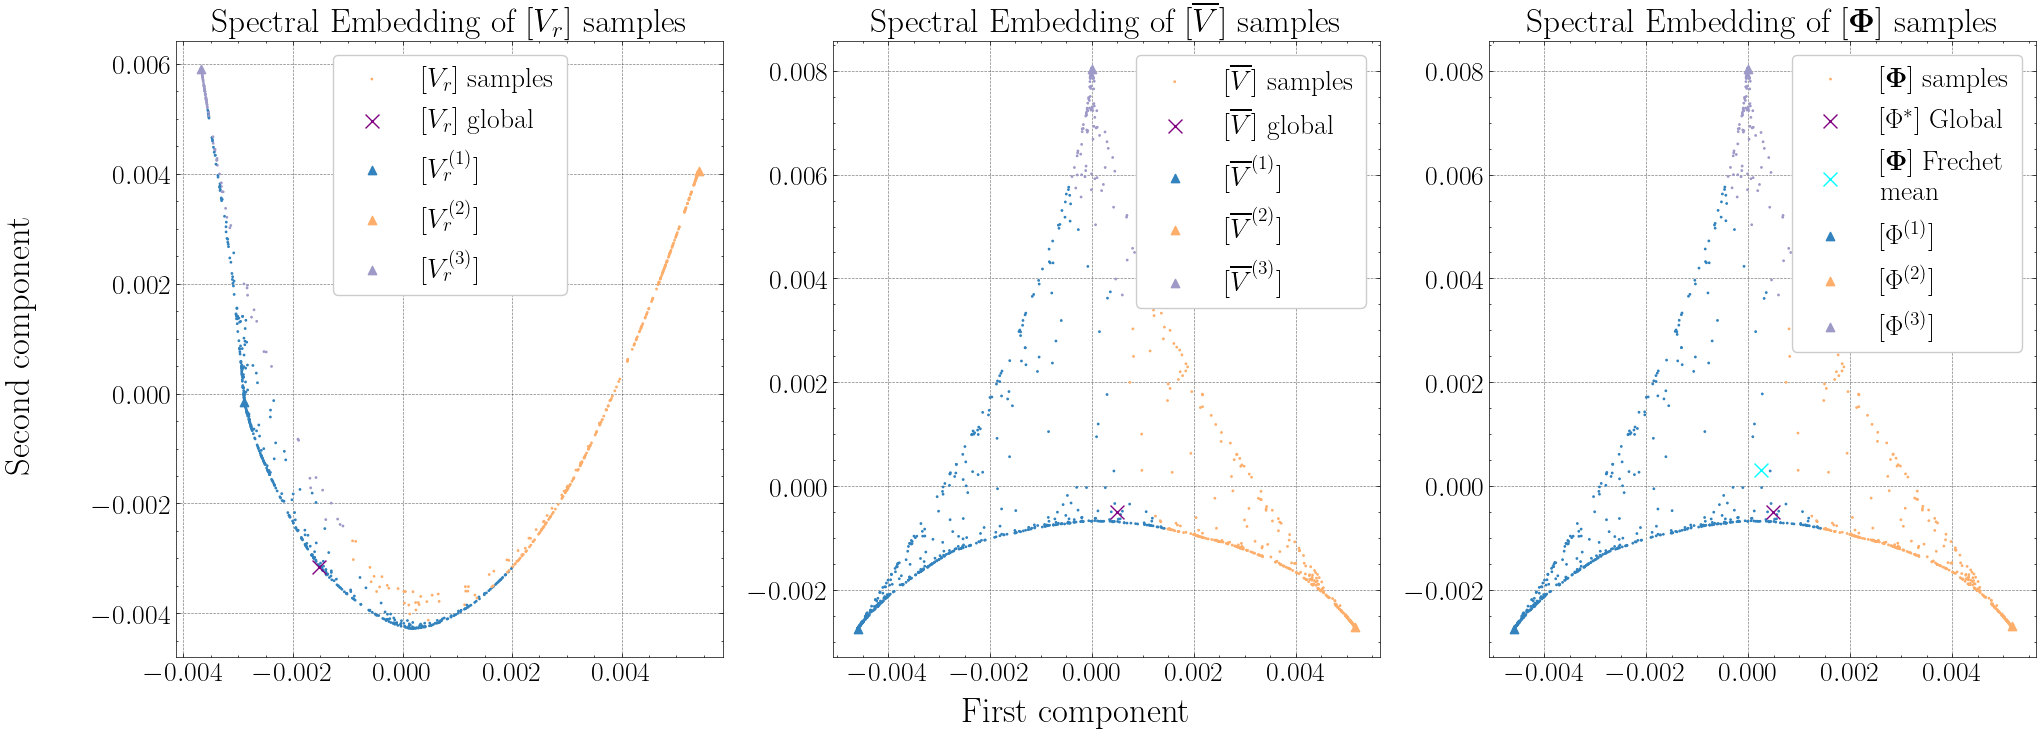

In [28]:
# Plot the embeddings
fig = plt.figure(figsize=(24, 8))

plt.subplot(1, 3, 1)
# plt.scatter(embedding_Vr[:-2, 0], embedding_Vr[:-2, 1], color='grey', s=1, label='Vr samples')
plt.scatter(
    embedding_Vr[:N_stiefel_samples, 0],
    embedding_Vr[:N_stiefel_samples, 1],
    color=colors[maxI],
    s=1,
    label="$[V_r]$ samples",
)
plt.scatter(
    embedding_Vr[-2, 0],
    embedding_Vr[-2, 1],
    color="purple",
    label="$[V_r]$ global",
    marker="x",
    s=100,
)
# plt.scatter(embedding_Vr[-1, 0], embedding_Vr[-1, 1], color='cyan', label='Vr Frechet mean', marker='x', s=100)


for i in range(len(Vr_lst_sel) - 1):
    plt.scatter(
        embedding_Vr[N_stiefel_samples + i, 0],
        embedding_Vr[N_stiefel_samples + i, 1],
        color=colors[i],
        label=r"$[V_r^{(" + str(i + 1) + ")}]$",
        marker="^",
    )
    # plt.scatter(embedding_Vr[-i-2, 0], embedding_Vr[-i-2, 1], label=f"Vr {names[-i-1]}, $\\beta$={beta[-1]:.2e}", marker='^', color=colors[i])

plt.legend()
plt.title("Spectral Embedding of $[V_r]$ samples")
# plt.xlabel('First component')
# plt.ylabel('Second component')


plt.subplot(1, 3, 2)
plt.scatter(
    embedding_Vbar[:N_stiefel_samples, 0],
    embedding_Vbar[:N_stiefel_samples, 1],
    color=colors[maxI],
    s=1,
    label="$[\overline{V}]$ samples",
)
plt.scatter(
    embedding_Vbar[-2, 0],
    embedding_Vbar[-2, 1],
    color="purple",
    label="$[\overline{V}]$ global",
    marker="x",
    s=100,
)
# plt.scatter(embedding_Vbar[-1, 0], embedding_Vbar[-1, 1], color='cyan', label='Vbar Frechet mean', marker='x', s=100)

for i in range(len(Vbar_lst_sel) - 1):
    plt.scatter(
        embedding_Vbar[N_stiefel_samples + i, 0],
        embedding_Vbar[N_stiefel_samples + i, 1],
        color=colors[i],
        label=r"$[\overline{V}^{(" + str(i + 1) + ")}]$",
        marker="^",
    )
    # print(f"Vbar {names_sel[-i-1]}")
    # plt.scatter(embedding_Vbar[-i-2, 0], embedding_Vbar[-i-2, 1], label=f"Vbar {names[-i-1]}, $\\beta$={beta[-1]:.2e}", marker='^', color=colors[i])


plt.legend()
plt.title("Spectral Embedding of $[\overline{V}]$ samples")


plt.subplot(1, 3, 3)
plt.scatter(
    embedding_V_combined[:N_stiefel_samples, 0],
    embedding_V_combined[:N_stiefel_samples, 1],
    color=colors[maxI],
    s=1,
    label="$[\mathbf{\Phi}]$ samples",
)
plt.scatter(
    embedding_V_combined[-2, 0],
    embedding_V_combined[-2, 1],
    color="purple",
    label="$[\Phi^*]$ Global",
    marker="x",
    s=100,
)
plt.scatter(
    embedding_V_combined[-1, 0],
    embedding_V_combined[-1, 1],
    color="cyan",
    label="$[\mathbf{\Phi}]$ Frechet \n mean",
    marker="x",
    s=100,
)

for i in range(len(V_combined_lst_stochastic) - 1):
    plt.scatter(
        embedding_V_combined[N_stiefel_samples + i, 0],
        embedding_V_combined[N_stiefel_samples + i, 1],
        color=colors[i],
        label=r"$[\Phi^{(" + str(i + 1) + ")}]$",
        marker="^",
    )
    # print(f"Vbar {names_sel[-i-1]}")

plt.legend()
plt.title("Spectral Embedding of $[\mathbf{\Phi}]$ samples")


# plt.xlabel('First component')
# plt.ylabel('Second component')

# Add common x and y labels
fig.text(0.5, 0.04, "First component", ha="center", va="center", fontsize=25)
fig.text(0.06, 0.5, "Second component", ha="center", va="center", rotation="vertical", fontsize=25)

plt.savefig("SE_StiefelSamples_KMeans_NS_q13_r3.pdf", bbox_inches="tight")

plt.show()

In [29]:
# Load mean and standard deviation
with np.load(f"/data1/jy384/research/Data/UnimodalSROB/ns/{variable}_s_rec_full_statistics.npz") as data:
    mean_s_rec = data['mean']
    std_s_rec = data['std_dev']


# load mean magnitude and standard deviation
magnitude_statistics_path = base_path / f"{variable}_velocity_magnitude_statistics.npz"
with np.load(magnitude_statistics_path) as data:
    mean_magnitude = data['mean_magnitude']
    std_magnitude = data['std_dev_magnitude']
    ci_upper_magnitude = data['upper_percentile']
    ci_lower_magnitude = data['lower_percentile']

In [30]:
vorticity_statistics_path = base_path / f"{variable}_vorticity_statistics.npz"
with np.load(vorticity_statistics_path) as data:
    mean_vorticity = data['mean_vorticity']
    std_vorticity = data['std_dev_vorticity']   
    ci_upper_vorticity = data['upper_percentile']
    ci_lower_vorticity = data['lower_percentile']

In [31]:
ci_lower_magnitude

array([[7.58913210e-06, 6.76568184e-06, 6.75537866e-06],
       [9.02304419e-06, 8.16820873e-06, 8.13467284e-06],
       [3.95206428e-01, 3.02122607e-01, 2.97345150e-01],
       ...,
       [1.49282610e+00, 1.49281418e+00, 1.49281871e+00],
       [1.48624265e+00, 1.48624456e+00, 1.48624408e+00],
       [1.48631203e+00, 1.48629940e+00, 1.48630368e+00]])

In [32]:
# compute vorticity
v_cg2 = element(
        "Lagrange", mymesh.topology.cell_name(), 2, shape=(mymesh.geometry.dim,)
    )
dg1 = element("DG", mymesh.topology.cell_name(), 1)

V = functionspace(mymesh, v_cg2)
Q = functionspace(mymesh, dg1)

# Create functions for velocity and vorticity
u = Function(V)
omega = Function(Q)

def compute_vorticity(u: Function, omega: Function, state, timestep):
    u.x.array[:] = state[:, timestep]
    ux, uy = u.split()
    vortex = uy.dx(0) - ux.dx(1)
    omega.interpolate(Expression(vortex, Q.element.interpolation_points()))
    vorticity_values = omega.x.array[:].copy()
    
    return vorticity_values

In [33]:
# Define a minimum time spacing between chosen timesteps (in seconds)
min_spacing = 0.5  # Adjust this value as needed

# Function to check if a timestep is far enough from already chosen timesteps
def is_far_enough(t, chosen, min_spacing, dt):
    return all(abs(t - c) >= min_spacing / dt for c in chosen)

# Identify timesteps with largest total variation
total_variation = np.sum(std_magnitude, axis=0)

# Set up time windows
dt = 0.005
training_start = 0  # Assuming training starts at t=4
extrapolation_start = int(5 / dt) - int(4 / dt)
training_end = extrapolation_start - 1

# Sort timesteps within training window by variation
training_variation = total_variation[:training_end+1]
sorted_training_timesteps = np.argsort(training_variation)[::-1]

# Sort timesteps within extrapolation window by variation
extrapolation_variation = total_variation[extrapolation_start:]
sorted_extrapolation_timesteps = np.argsort(extrapolation_variation)[::-1] + extrapolation_start

chosen_timesteps = []

# Select two timesteps from training window
for t in sorted_training_timesteps:
    if len(chosen_timesteps) < 2 and is_far_enough(t, chosen_timesteps, min_spacing, dt):
        chosen_timesteps.append(t)
    if len(chosen_timesteps) == 2:
        break

# If we couldn't find 2 timesteps with the desired spacing, relax the spacing constraint
if len(chosen_timesteps) < 2:
    for t in sorted_training_timesteps:
        if t not in chosen_timesteps:
            chosen_timesteps.append(t)
        if len(chosen_timesteps) == 2:
            break

# Select one timestep from extrapolation window
for t in sorted_extrapolation_timesteps:
    if is_far_enough(t, chosen_timesteps, min_spacing, dt):
        chosen_timesteps.append(t)
        break

# If we couldn't find a timestep in extrapolation with the desired spacing, take the highest variation one
if len(chosen_timesteps) < 3:
    chosen_timesteps.append(sorted_extrapolation_timesteps[0])

# Sort the chosen timesteps
chosen_timesteps.sort()

print(f"Chosen timesteps: {[t*dt + 4 for t in chosen_timesteps]}")
print(f"Corresponding variations: {total_variation[chosen_timesteps]}")

Chosen timesteps: [4.26, 4.815, 7.975]
Corresponding variations: [1045.7859 1077.2234 1282.1063]


In [42]:
vmin_mean = np.nanmin([np.nanmin(mean_magnitude[:, t]) for t in chosen_timesteps])
vmax_mean = np.nanmax([np.nanmax(mean_magnitude[:, t]) for t in chosen_timesteps])
# vmin_ci = np.nanmin([np.nanmin(2 * 1.96 * std_magnitude[:, t]) for t in chosen_timesteps])
# vmax_ci = np.nanmax([np.nanmax(2 * 1.96 * std_magnitude[:, t]) for t in chosen_timesteps])

In [35]:
# import pyvista as pv
# import numpy as np

# grid = pv.UnstructuredGrid(*plot.vtk_mesh(mymesh))

# def create_pyvista_plot(grid, primary_data, QoI, std=None, plot_type='mean', title='', colormap='viridis', clim=None):
#     plotter = pv.Plotter(off_screen=True)
    
#     # Add the primary data to the grid
#     grid.point_data[QoI] = primary_data
    
#     # Add the mesh to the plotter
#     plotter.add_mesh(grid, scalars=QoI, cmap=colormap, clim=clim, show_edges=False, lighting=True, specular=0.5, diffuse=0.5, ambient=0.5)
    
#     mean_min = np.nanmin(primary_data)
#     mean_max = np.nanmax(primary_data)
    
#     if plot_type == 'mean_with_ci':
#         # Assume primary_data is mean and secondary_data is std
#         lower_bound = np.maximum(primary_data - 1.96 * std, 0)
#         upper_bound = primary_data + 1.96 * std
        
#         # Add lower bound contours (blue)
#         lower_cntrs = np.linspace(np.nanmin(lower_bound), mean_min, 4)
#         lower_contours = grid.contour(isosurfaces=lower_cntrs, scalars=lower_bound)
#         if lower_contours.n_points > 0:
#             plotter.add_mesh(lower_contours, color='black', line_width=2, style='wireframe', opacity=[0.25, 0.5, 0.75, 1], label='Lower 95% CI')
        
#         # Add upper bound contours (red)
#         upper_cntrs = np.linspace(mean_max, np.nanmax(upper_bound), 4)
#         upper_contours = grid.contour(isosurfaces=upper_cntrs, scalars=upper_bound)
#         if upper_contours.n_points > 0:
#             plotter.add_mesh(upper_contours, color='green', line_width=2, style='wireframe', opacity=[0.25, 0.5, 0.75, 1], label='Upper 95% CI')
            
#         plotter.add_legend()
        
        
#         # mean = primary_data
          
#         # # Define CI levels
#         # ci_levels = [68, 95, 99]
#         # colors = ['lightblue', 'blue', 'darkblue']  # for lower bounds
        
#         # lower_cntrs = []
#         # upper_cntrs = []
        
#         # for i, level in enumerate(ci_levels):
#         #     z_score = scipy.stats.norm.ppf((1 + level/100) / 2)
#         #     lower_ci = np.maximum(mean - z_score * std, 0)
#         #     upper_ci = mean + z_score * std
            
#         #     lower_cntrs.append(lower_ci)
#         #     upper_cntrs.append(upper_ci)
        
            
#         # # Add lower bound contours
#         # lower_contours = grid.contour(isosurfaces=, scalars=lower_ci)
#         # if lower_contours.n_points > 0:
#         #     plotter.add_mesh(lower_contours, color=colors[i], line_width=2, style='wireframe', opacity=0.5+0.25*i)
            
#         # # Add upper bound contours
#         # upper_contours = grid.contour(isosurfaces=[upper_ci], scalars=upper_ci)
#         # if upper_contours.n_points > 0:
#         #     plotter.add_mesh(upper_contours, color=colors[i].replace('blue', 'red'), line_width=2, style='wireframe', opacity=0.5+0.25*i)
    
#         # # Add annotations
#         # plotter.add_text("CI Levels:", position=(0.05, 0.95), font_size=10)
#         # for i, level in enumerate(ci_levels):
#         #     plotter.add_text(f"{level}%", position=(0.05, 0.92 - 0.03*i), font_size=8, color=colors[i])

    
#     elif plot_type == 'ci_width':
#         # Assume primary_data is already the CI width
#         pass  # We've already plotted the primary data as a color map
    
#     # Set the camera position for a top-down view
#     plotter.view_xy()
#     plotter.camera.tight() 
#     # # Set title
#     # plotter.add_text(title, position='upper_edge', font_size=10)
    
#     return plotter

# # Main plotting code
# fig, axes = plt.subplots(3, 2, figsize=(15, 8))
# # fig.suptitle("Magnitude and Uncertainty at Selected Timesteps")

# vmin_mean = np.nanmin([np.nanmin(mean_magnitude[:, t]) for t in chosen_timesteps])
# vmax_mean = np.nanmax([np.nanmax(mean_magnitude[:, t]) for t in chosen_timesteps])
# vmin_ci = np.nanmin([np.nanmin(2 * 1.96 * std_magnitude[:, t]) for t in chosen_timesteps])
# vmax_ci = np.nanmax([np.nanmax(2 * 1.96 * std_magnitude[:, t]) for t in chosen_timesteps])

# for i, t in enumerate(chosen_timesteps):
#     # Plot mean magnitude with CI contours
#     QoI = "Velocity Magnitude"
#     mean_plotter = create_pyvista_plot(
#         grid, 
#         primary_data=mean_magnitude[:, t], 
#         QoI=QoI,
#         std=std_magnitude[:, t],
#         plot_type='mean_with_ci',
#         title=f"Mean Magnitude at Time: {t*dt + 4:.3f}",
#         colormap='coolwarm',
#         clim=[vmin_mean, vmax_mean]
#     )
#     mean_image = mean_plotter.screenshot(transparent_background=True, scale=3)
#     axes[i, 0].imshow(mean_image)
#     axes[i, 0].axis('off')
#     axes[i, 0].set_title(f"Mean Magnitude at Time: {t*dt + 4:.3f}")
    
#     # Plot confidence interval width
#     upper_bound = mean_magnitude[:, t] + 1.96 * std_magnitude[:, t]
#     lower_bound = np.maximum(mean_magnitude[:, t] - 1.96 * std_magnitude[:, t], 0)
#     ci_width = upper_bound - lower_bound
#     ci_plotter = create_pyvista_plot(
#         grid, 
#         primary_data=ci_width,
#         QoI="Velocity CI Width",
#         plot_type='ci_width',
#         title=f"Uncertainty at Time: {t*dt + 4:.3f}",
#         colormap='RdYlBu_r',
#         clim=[vmin_ci, vmax_ci]
#     )
#     ci_image = ci_plotter.screenshot(transparent_background=True, scale=3)
#     axes[i, 1].imshow(ci_image)
#     axes[i, 1].axis('off')
#     axes[i, 1].set_title(f"Uncertainty at Time: {t*dt + 4:.3f}")
    
#     # Clear plotters to free memory
#     mean_plotter.clear()
#     ci_plotter.clear()

# # Rest of the code remains the same

# plt.tight_layout()

# # Add caption as text
# caption = """
# Guide to interpreting the plots:

# Left column (Mean Magnitude):
# - Color contours show the mean magnitude of the flow.
# - Black contour lines with labels indicate specific mean magnitude values.
# - Blue dashed lines represent the lower bound of the 95% confidence interval (CI).
# - Red dashed lines represent the upper bound of the 95% CI.
# - Wider gaps between red and blue lines indicate higher uncertainty.

# Right column (Uncertainty):
# - Color contours represent the width of the 95% CI.
# - Darker blue areas indicate lower uncertainty, while darker red areas indicate higher uncertainty.

# General interpretation:
# - Compare left and right plots to understand how uncertainty relates to mean magnitude.
# - Areas with complex, closely spaced contours suggest rapidly changing flow characteristics or uncertainty levels.
# - Pay attention to uncertainty in key regions like near the cylinder and in the wake.

# The cylinder is represented by the white circle, and the flow direction is from left to right.
# """

# # fig.text(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

# plt.savefig("magnitude_uncertainty_plot_pyvista_with_ci_contours.png", dpi=300, bbox_inches='tight')
# plt.show()

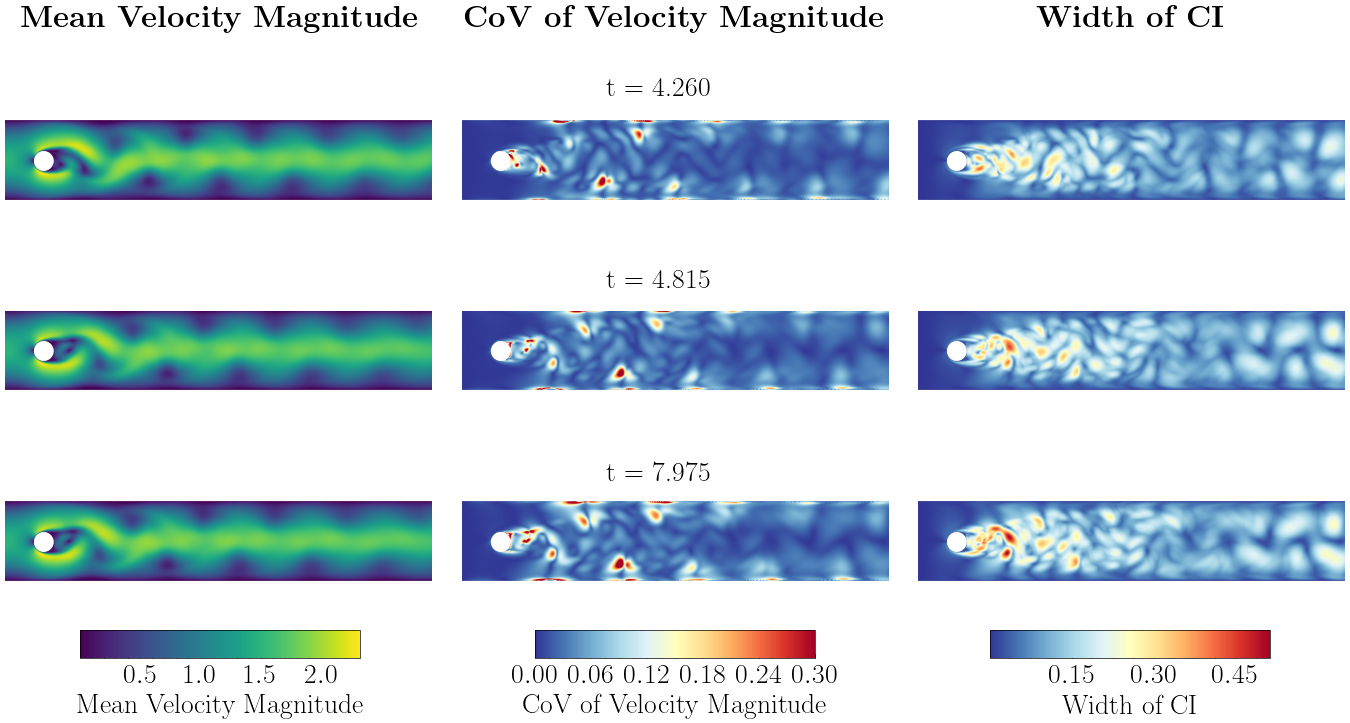

In [62]:
grid = pv.UnstructuredGrid(*plot.vtk_mesh(mymesh))

def create_pyvista_plot(grid, primary_data, QoI, colormap='viridis', clim=None):
    plotter = pv.Plotter(off_screen=True)
    
    # Add the primary data to the grid
    grid.point_data[QoI] = primary_data
    
    # Add the mesh to the plotter
    plotter.add_mesh(grid, scalars=QoI, cmap=colormap, clim=clim, show_edges=False, lighting=False, show_scalar_bar=False)
    
    # Set the camera position for a top-down view
    plotter.view_xy()
    plotter.camera.tight()
    # # Set title
    # plotter.add_text(title, position='upper_edge', font_size=10)
    
    return plotter


def create_CV_plot(grid, primary_data, QoI, std=None, plot_type='mean', title='', colormap='viridis', clim=None):
    plotter = pv.Plotter(off_screen=True)
    
    # Add the primary data to the grid
    grid.point_data[QoI] = primary_data
    
    # Add the mesh to the plotter
    plotter.add_mesh(grid, scalars=QoI, cmap=colormap, clim=clim, show_edges=False, lighting=True, specular=0.5, diffuse=0.5, ambient=0.5)
    
    mean_min = np.nanmin(primary_data)
    mean_max = np.nanmax(primary_data)
    
    if plot_type == 'mean_with_ci':
        # Assume primary_data is mean and secondary_data is std
        lower_bound = np.maximum(primary_data - 1.96 * std, 0)
        upper_bound = primary_data + 1.96 * std
        
        # Add lower bound contours (blue)
        lower_cntrs = np.linspace(np.nanmin(lower_bound), mean_min, 4)
        lower_contours = grid.contour(isosurfaces=lower_cntrs, scalars=lower_bound)
        if lower_contours.n_points > 0:
            plotter.add_mesh(lower_contours, color='black', line_width=2, style='wireframe', opacity=[0.25, 0.5, 0.75, 1], label='Lower 95% CI')
        
        # Add upper bound contours (red)
        upper_cntrs = np.linspace(mean_max, np.nanmax(upper_bound), 4)
        upper_contours = grid.contour(isosurfaces=upper_cntrs, scalars=upper_bound)
        if upper_contours.n_points > 0:
            plotter.add_mesh(upper_contours, color='green', line_width=2, style='wireframe', opacity=[0.25, 0.5, 0.75, 1], label='Upper 95% CI')
            
        plotter.add_legend()

    
    elif plot_type == 'ci_width':
        # Assume primary_data is already the CI width
        pass  # We've already plotted the primary data as a color map
    
    # Set the camera position for a top-down view
    plotter.view_xy()
    plotter.camera.tight() 
    # # Set title
    # plotter.add_text(title, position='upper_edge', font_size=10)
    
    return plotter


def create_uncertainty_plot(
    grid, mean_data, std_data, mean_colormap="viridis", cv_colormap="RdYlBu_r", title=""
):
    plotter = pv.Plotter(off_screen=True)

    # Add mean flow data
    grid.point_data["Velocity Magnitude"] = mean_data
    grid.set_active_scalars("Velocity Magnitude")
    # mean_actor = plotter.add_mesh(grid, scalars='Mean Vorticity', cmap=mean_colormap, show_edges=False, lighting=False)

    # Calculate coefficient of variation (CV)
    cv = np.where(mean_data != 0, std_data / mean_data, 0)
    grid.point_data["CV"] = cv

    # Create uncertainty contours
    uncertainty_levels = np.percentile(cv, [75, 90, 95])
    print(uncertainty_levels)

    level_contour = grid.contour(isosurfaces=uncertainty_levels, scalars="CV")
    cv_actor = plotter.add_mesh(
        level_contour,
        scalars="CV",
        cmap=cv_colormap,
        show_edges=False,
        lighting=False,
        style="wireframe",
        opacity=0.5,
        line_width=6,
        scalar_bar_args=dict(
            title="CV",
            vertical=True,
            position_x=0.85,
            position_y=0.25,
            width=0.05,
            height=0.6,
        ),
    )
    mean_actor = plotter.add_mesh(
        grid,
        scalars="Velocity Magnitude",
        cmap=mean_colormap,
        show_edges=False,
        lighting=False,
    )

    plotter.view_xy()
    plotter.camera.tight()
    plotter.add_title(title)

    return plotter


fig, axes = plt.subplots(3, 3, figsize=(14, 7))

# Add column titles
col_titles = [r"\textbf{Mean Velocity Magnitude}", r"\textbf{CoV of Velocity Magnitude}", r"\textbf{Width of CI}"]
for col, title in enumerate(col_titles):
    # fig.text(0.25 + col*0.3, 0.9, title, ha='center', va='center', fontweight='bold')
    fig.text(0.175 + col*0.325, 0.975, title, ha='center', va='center', fontsize=22.5)


vmin_mean = np.nanmin([np.nanmin(mean_magnitude[:, t]) for t in chosen_timesteps])
vmax_mean = np.nanmax([np.nanmax(mean_magnitude[:, t]) for t in chosen_timesteps])

upper_bounds = np.array([ci_upper_magnitude[:, i] for i in range(3)])
lower_bounds = np.array([ci_lower_magnitude[:, i] for i in range(3)])
ci_widths = upper_bounds - lower_bounds
vmin_ci = np.nanmin([np.nanmin(ci_widths[i, :]) for i in range(3)])
vmax_ci = np.nanmax([np.nanmax(ci_widths[i, :]) for i in range(3)])

# vmin_ci = np.nanmin(
#     [np.nanmin(2 * 1.96 * std_magnitude[:, t]) for t in chosen_timesteps]
# )
# vmax_ci = np.nanmax(
#     [np.nanmax(2 * 1.96 * std_magnitude[:, t]) for t in chosen_timesteps]
# )

time_labels = [f"t = {t*dt + 4:.3f}" for t in chosen_timesteps]

# Usage in main code
for i, t in enumerate(chosen_timesteps):
    # fig.text(0.1, 0.775 - i*0.285, time_labels[i], va='center', ha='right', rotation=0)
    fig.text(0.525, 0.875 - i*0.275, time_labels[i], va='center', ha='right', rotation=0)
    mean_plotter = create_pyvista_plot(
        grid,
        primary_data=mean_magnitude[:, t],
        QoI="Mean Velocity Magnitude",
        colormap="viridis",
        clim=(vmin_mean, vmax_mean),
    )
    image = mean_plotter.screenshot(transparent_background=True, scale=3)
    axes[i, 0].imshow(image)
    axes[i, 0].axis("off")
    # axes[i, 0].set_title(f"Mean Velocity Magnitude, t={t*dt + 4:.3f}")
    
    # # make colorbar using min and max of mean
    # cbar = plt.colorbar(
    #     ScalarMappable(
    #         cmap="viridis",
    #         norm=Normalize(vmin=vmin_mean, vmax=vmax_mean),
    #     ),
    #     ax=axes[i, 0],
    #     label="Mean Velocity Magnitude",
    #     orientation="horizontal",)
    
    
    cv = np.where(mean_magnitude[:, t] != 0, std_magnitude[:, t] / mean_magnitude[:, t], 0)
    cv_plotter = create_pyvista_plot(
        grid,
        primary_data=cv,
        QoI="CoV of Velocity Magnitude",
        colormap="RdYlBu_r",
        clim=(0, 0.3),
    )
    cv_image = cv_plotter.screenshot(transparent_background=True, scale=3)
    axes[i, 1].imshow(cv_image)
    axes[i, 1].axis("off")
    # axes[i, 1].set_title(f"CoV of Velocity Magnitude, t={t*dt + 4:.3f}")
    
    # cbar = plt.colorbar(
    #     ScalarMappable(
    #         cmap="RdYlBu_r",
    #         norm=Normalize(vmin=0, vmax=0.3),
    #     ),
    #     ax=axes[i, 1],
    #     label="CoV of Velocity Magnitude",
    #     orientation="horizontal",)
    

    # Plot confidence interval width
    # upper_bound = mean_magnitude[:, t] + 1.96 * std_magnitude[:, t]
    # lower_bound = np.maximum(mean_magnitude[:, t] - 1.96 * std_magnitude[:, t], 0)
    upper_bound = ci_upper_magnitude[:, i]
    lower_bound = ci_lower_magnitude[:, i]
    ci_width = upper_bound - lower_bound
    
    ci_plotter = create_pyvista_plot(
        grid,
        primary_data=ci_width,
        QoI="Velocity Magnitude CI Width",
        colormap="RdYlBu_r",
        clim=[vmin_ci, vmax_ci],
    )
    ci_image = ci_plotter.screenshot(transparent_background=True, scale=3)
    axes[i, 2].imshow(ci_image)
    axes[i, 2].axis("off")
    # axes[i, 2].set_title(f"Width of CI, t={t*dt + 4:.3f}")
    
    # cbar = plt.colorbar(
    #     ScalarMappable(
    #         cmap="RdYlBu_r",
    #         norm=Normalize(vmin=vmin_ci, vmax=vmax_ci),
    #     ),
    #     ax=axes[i, 2],
    #     label="Width of CI",
    #     orientation="horizontal",)

    # Clear plotters to free memory
    mean_plotter.clear()
    cv_plotter.clear()
    ci_plotter.clear()
    
# Add single colorbar for each column
from matplotlib import ticker
nbins = 5
for col in range(3):
    # cax = fig.add_axes([0.156 + col*0.295, 0.06, 0.2, 0.04])
    cax = fig.add_axes([0.075 + col*0.325, 0.06, 0.2, 0.04])
    if col == 0:
        cbar = plt.colorbar(ScalarMappable(cmap="viridis", norm=Normalize(vmin=vmin_mean, vmax=vmax_mean)),
                            cax=cax, orientation="horizontal")
        tick_locator = ticker.MaxNLocator(nbins=nbins)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.set_label("Mean Velocity Magnitude")
    elif col == 1:
        cbar = plt.colorbar(ScalarMappable(cmap="RdYlBu_r", norm=Normalize(vmin=0, vmax=0.3)),
                            cax=cax, orientation="horizontal")
        tick_locator = ticker.MaxNLocator(nbins=nbins)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.set_label("CoV of Velocity Magnitude")
    else:
        cbar = plt.colorbar(ScalarMappable(cmap="RdYlBu_r", norm=Normalize(vmin=vmin_ci, vmax=vmax_ci)),
                            cax=cax, orientation="horizontal")
        tick_locator = ticker.MaxNLocator(nbins=nbins)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.set_label("Width of CI")

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("magnitude_uncertainty_plot_pyvista.pdf", bbox_inches='tight')

In [38]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.interpolate import griddata
# from matplotlib.colors import TwoSlopeNorm
# from matplotlib.patches import Patch
# from matplotlib.lines import Line2D

# coordinates = mymesh.geometry.x


# def create_cylinder_mask(X, Y, center_x, center_y, radius):
#     return (X - center_x)**2 + (Y - center_y)**2 > radius**2


# def plot_magnitude_with_uncertainty(mean, std, coordinates, timestep, dt, fig, ax1, ax2, vmin_mean, vmax_mean, vmin_ci, vmax_ci):
#     x, y = coordinates[:, 0], coordinates[:, 1]
    
#     xi = np.linspace(x.min(), x.max(), 200)
#     yi = np.linspace(y.min(), y.max(), 200)
#     X, Y = np.meshgrid(xi, yi)
    
#     cylinder_mask = create_cylinder_mask(X, Y, 0.2, 0.2, 0.05)
    
#     mean_grid = griddata((x, y), mean, (X, Y), method='cubic')
#     std_grid = griddata((x, y), std, (X, Y), method='cubic')
    
#     mean_grid[~cylinder_mask] = np.nan
#     std_grid[~cylinder_mask] = np.nan
    
#     # Plot mean magnitude
#     im1 = ax1.contourf(X, Y, mean_grid, levels=20, cmap='viridis', vmin=vmin_mean, vmax=vmax_mean)
#     cbar1 = fig.colorbar(im1, ax=ax1, label='Mean Magnitude')
#     ax1.set_title(f"Mean Magnitude at Time: {timestep*dt + 4:.3f}")  # Increase padding for legend
    
#     # Add contour lines to mean plot
#     cs1 = ax1.contour(X, Y, mean_grid, levels=10, colors='k', alpha=0.5, linewidths=0.5)
#     ax1.clabel(cs1, inline=True, fontsize=8, fmt='%.2f')
    
#     # Calculate and plot confidence interval bounds
#     upper_bound = mean_grid + 1.96 * std_grid
#     lower_bound = np.maximum(mean_grid - 1.96 * std_grid, 0)
    
#     lower_levels = np.linspace(np.nanmin(lower_bound), vmin_mean, num=4)
#     print(lower_levels)
#     upper_levels = np.linspace(vmax_mean, np.nanmax(upper_bound), num=4)
#     print(upper_levels)
    
#     cl1 = ax1.contour(X, Y, lower_bound, levels=lower_levels, colors='blue', linestyles='dashed', linewidths=1)
#     cu1 = ax1.contour(X, Y, upper_bound, levels=upper_levels, colors='red', linestyles='dashed', linewidths=1)
    
#     ax1.clabel(cl1, inline=True, fontsize=8, fmt='%.2f')
#     ax1.clabel(cu1, inline=True, fontsize=8, fmt='%.2f')
    
#     # Plot confidence interval width
#     ci_width = 2 * 1.96 * std_grid  # 95% CI width
#     norm = TwoSlopeNorm(vmin=vmin_ci, vcenter=(vmin_ci + vmax_ci)/2, vmax=vmax_ci)
#     im2 = ax2.contourf(X, Y, ci_width, levels=20, cmap='RdYlBu_r', norm=norm)
#     cbar2 = fig.colorbar(im2, ax=ax2, label='95\% CI Width')
#     ax2.set_title(f"Uncertainty at Time: {timestep*dt + 4:.3f}")  # Increase padding for legend
    
#     # Add contour lines to uncertainty plot
#     cs2 = ax2.contour(X, Y, ci_width, levels=10, colors='k', alpha=0.5, linewidths=0.5)
#     ax2.clabel(cs2, inline=True, fontsize=8, fmt='%.2f')
    
#     for ax in [ax1, ax2]:
#         ax.set_aspect('equal')
#         ax.set_xlabel('X')
#         ax.set_ylabel('Y')
#         ax.add_patch(plt.Circle((0.2, 0.2), 0.05, color='white', ec='black'))
#         ax.annotate("Cylinder", xy=(0.2, 0.2), xytext=(0.3, 0.3), arrowprops=dict(arrowstyle="->"))
#         ax.annotate("Wake", xy=(1.0, 0.2), xytext=(1.2, 0.3), arrowprops=dict(arrowstyle="->"))
    
#     # Add legend to mean plot
#     legend_elements = [
#         Line2D([0], [0], color='blue', linestyle='--', label='Lower 95% CI'),
#         Line2D([0], [0], color='red', linestyle='--', label='Upper 95% CI')
#     ]
#     ax1.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=2)

#     return fig

# # Main plotting code
# fig, axes = plt.subplots(3, 2, figsize=(20, 15))
# fig.suptitle("Magnitude and Uncertainty at Selected Timesteps", fontsize=16)

# vmin_mean = np.nanmin([np.nanmin(mean_magnitude[:, t]) for t in chosen_timesteps])
# vmax_mean = np.nanmax([np.nanmax(mean_magnitude[:, t]) for t in chosen_timesteps])
# vmin_ci = np.nanmin([np.nanmin(2 * 1.96 * std_magnitude[:, t]) for t in chosen_timesteps])
# vmax_ci = np.nanmax([np.nanmax(2 * 1.96 * std_magnitude[:, t]) for t in chosen_timesteps])

# for i, t in enumerate(chosen_timesteps):
#     fig = plot_magnitude_with_uncertainty(mean_magnitude[:, t], std_magnitude[:, t], coordinates, t, dt, fig, axes[i, 0], axes[i, 1], vmin_mean, vmax_mean, vmin_ci, vmax_ci)

# plt.tight_layout()

# # Add caption as text
# caption = """
# Guide to interpreting the plots:

# Left column (Mean Magnitude):
# - Color contours show the mean magnitude of the flow.
# - Black contour lines with labels indicate specific mean magnitude values.
# - Blue dashed lines represent the lower bound of the 95% confidence interval (CI).
# - Red dashed lines represent the upper bound of the 95% CI.
# - Wider gaps between red and blue lines indicate higher uncertainty.

# Right column (Uncertainty):
# - Color contours represent the width of the 95% CI.
# - Darker blue areas indicate lower uncertainty, while darker red areas indicate higher uncertainty.
# - Black contour lines with labels show specific CI width values.

# General interpretation:
# - Compare left and right plots to understand how uncertainty relates to mean magnitude.
# - Areas with complex, closely spaced contours suggest rapidly changing flow characteristics or uncertainty levels.
# - Pay attention to uncertainty in key regions like near the cylinder and in the wake.

# The cylinder is represented by the white circle, and the flow direction is from left to right.
# """

# # fig.text(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

# plt.savefig("/data1/jy384/research/Data/UnimodalSROB/ns/magnitude_uncertainty_plot_enhanced.png", dpi=300, bbox_inches='tight')
# plt.show()

In [42]:
# Define a minimum time spacing between chosen timesteps (in seconds)
min_spacing = 0.5  # Adjust this value as needed

# Function to check if a timestep is far enough from already chosen timesteps
def is_far_enough(t, chosen, min_spacing, dt):
    return all(abs(t - c) >= min_spacing / dt for c in chosen)

# Identify timesteps with largest total variation
total_variation = np.sum(std_vorticity, axis=0)

# Set up time windows
dt = 0.005
training_start = 0  # Assuming training starts at t=4
extrapolation_start = int(5 / dt) - int(4 / dt)
training_end = extrapolation_start - 1

# Sort timesteps within training window by variation
training_variation = total_variation[:training_end+1]
sorted_training_timesteps = np.argsort(training_variation)[::-1]

# Sort timesteps within extrapolation window by variation
extrapolation_variation = total_variation[extrapolation_start:]
sorted_extrapolation_timesteps = np.argsort(extrapolation_variation)[::-1] + extrapolation_start

chosen_timesteps = []

# Select two timesteps from training window
for t in sorted_training_timesteps:
    if len(chosen_timesteps) < 2 and is_far_enough(t, chosen_timesteps, min_spacing, dt):
        chosen_timesteps.append(t)
    if len(chosen_timesteps) == 2:
        break

# If we couldn't find 2 timesteps with the desired spacing, relax the spacing constraint
if len(chosen_timesteps) < 2:
    for t in sorted_training_timesteps:
        if t not in chosen_timesteps:
            chosen_timesteps.append(t)
        if len(chosen_timesteps) == 2:
            break

# Select one timestep from extrapolation window
for t in sorted_extrapolation_timesteps:
    if is_far_enough(t, chosen_timesteps, min_spacing, dt):
        chosen_timesteps.append(t)
        break

# If we couldn't find a timestep in extrapolation with the desired spacing, take the highest variation one
if len(chosen_timesteps) < 3:
    chosen_timesteps.append(sorted_extrapolation_timesteps[0])

# Sort the chosen timesteps
chosen_timesteps.sort()

print(f"Chosen timesteps: {[t*dt + 4 for t in chosen_timesteps]}")
print(f"Corresponding variations: {total_variation[chosen_timesteps]}")

Chosen timesteps: [4.26, 4.815, 7.970000000000001]
Corresponding variations: [69885.25774815 71103.2789841  77776.34261112]


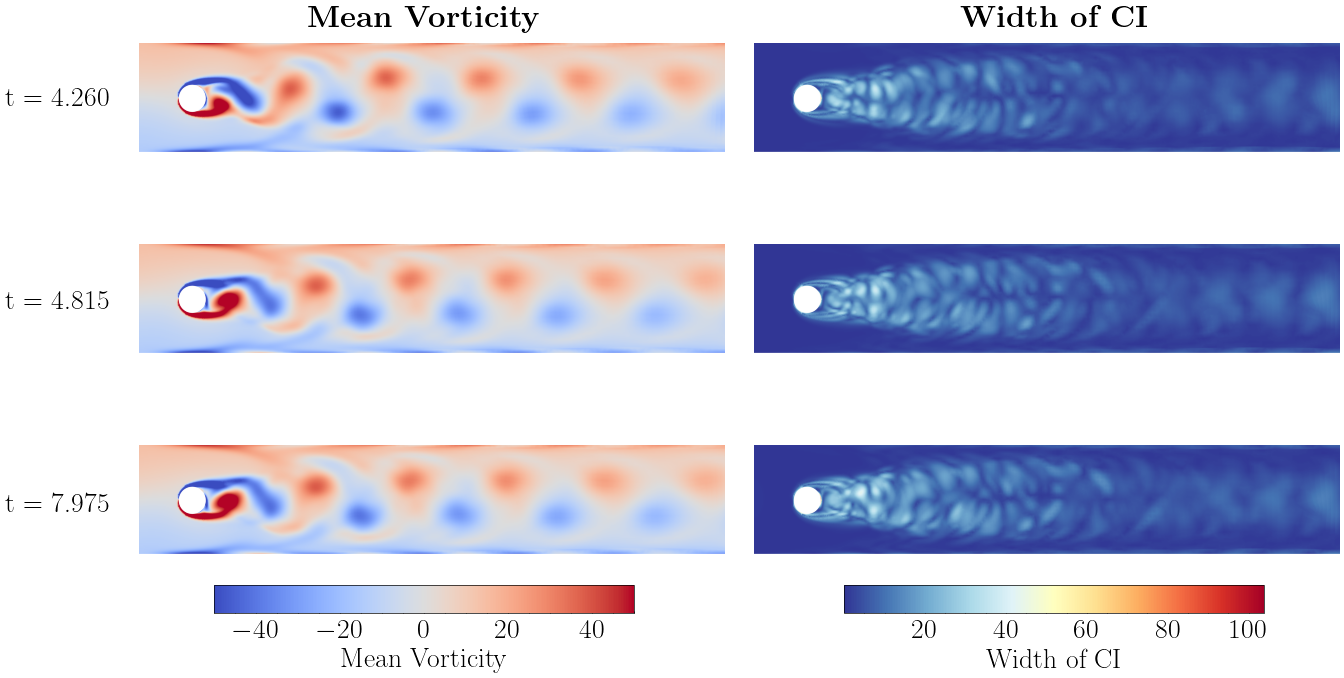

In [63]:
cells, types, x = plot.vtk_mesh(Q)
grid = pv.UnstructuredGrid(cells, types, x)


def create_uncertainty_plot(
    grid, mean_data, std_data, mean_colormap="viridis", cv_colormap="RdYlBu_r", QoI='Vorticity', clim=None
):
    plotter = pv.Plotter(off_screen=True)

    # Add mean flow data
    grid.point_data[QoI] = mean_data
    grid.set_active_scalars(QoI)
    # mean_actor = plotter.add_mesh(grid, scalars='Mean Vorticity', cmap=mean_colormap, show_edges=False, lighting=False)

    # Calculate coefficient of variation (CV)
    cv = np.where(mean_data != 0, std_data / mean_data, 0)
    grid.point_data["CV"] = cv

    # Create uncertainty contours
    uncertainty_levels = np.percentile(cv, [75, 90, 95])
    print(uncertainty_levels)    

    level_contour = grid.contour(isosurfaces=uncertainty_levels, scalars="CV")
    cv_actor = plotter.add_mesh(
        level_contour,
        scalars="CV",
        cmap=cv_colormap,
        show_edges=False,
        lighting=False,
        style="wireframe",
        opacity=0.5,
        line_width=6,
        scalar_bar_args=dict(
            title="CV",
            vertical=True,
            position_x=0.85,
            position_y=0.25,
            width=0.05,
            height=0.6,
        ),
    )
    
    if clim is not None:
        clim = clim
    else:
        clim = (np.min(mean_data), np.max(mean_data))

    mean_actor = plotter.add_mesh(
        grid,
        scalars=QoI,
        cmap=mean_colormap,
        show_edges=False,
        lighting=False,
        clim=clim,
    )

    plotter.view_xy()
    plotter.camera.tight()

    return plotter


def create_pyvista_plot_vort(grid, primary_data, QoI, std=None, plot_type='mean', title='', colormap='viridis', clim=None):
    plotter = pv.Plotter(off_screen=True)
    
    # Add the primary data to the grid
    grid.point_data[QoI] = primary_data
    
    # Add the mesh to the plotter
    plotter.add_mesh(grid, scalars=QoI, cmap=colormap, clim=clim, show_edges=False, lighting=False)
    
    if plot_type == 'mean_with_ci':
        # Assume primary_data is mean and secondary_data is std
        lower_bound = primary_data - 1.96 * std
        upper_bound = primary_data + 1.96 * std
        
        # Add lower bound contours (blue)
        lower_cntrs = np.linspace(np.nanmin(lower_bound), np.nanmax(lower_bound), 4)
        lower_contours = grid.contour(isosurfaces=lower_cntrs, scalars=lower_bound)
        if lower_contours.n_points > 0:
            plotter.add_mesh(lower_contours, color='blue', line_width=2, style='wireframe', opacity=1, label='Lower 95% CI')
        
        # Add upper bound contours (red)
        upper_cntrs = np.linspace(np.nanmin(upper_bound), np.nanmax(upper_bound), 4)
        upper_contours = grid.contour(isosurfaces=upper_cntrs, scalars=upper_bound)
        if upper_contours.n_points > 0:
            plotter.add_mesh(upper_contours, color='red', line_width=2, style='wireframe', opacity=1, label='Upper 95% CI')
            
        plotter.add_legend()

    
    elif plot_type == 'ci_width':
        # Assume primary_data is already the CI width
        pass  # We've already plotted the primary data as a color map
    
    # Set the camera position for a top-down view
    plotter.view_xy()
    plotter.camera.tight() 
    # # Set title
    # plotter.add_text(title, position='upper_edge', font_size=10)
    
    return plotter


def extremities(array, pct):
    # assert 50 <= pct <= 100
    return np.percentile(array, [100 - pct, pct])

# Main plotting code
fig, axes = plt.subplots(3, 2, figsize=(14, 7))
# fig.suptitle("Magnitude and Uncertainty at Selected Timesteps")

vmin_mean = np.nanmin([np.nanmin(mean_vorticity[:, t]) for t in chosen_timesteps])
vmax_mean = np.nanmax([np.nanmax(mean_vorticity[:, t]) for t in chosen_timesteps])
# vmin_ci = np.nanmin([np.nanmin(2 * 1.96 * std_vorticity[:, t]) for t in chosen_timesteps])
# vmax_ci = np.nanmax([np.nanmax(2 * 1.96 * std_vorticity[:, t]) for t in chosen_timesteps])

upper_bounds = np.array([ci_upper_vorticity[:, i] for i in range(3)])
lower_bounds = np.array([ci_lower_vorticity[:, i] for i in range(3)])
ci_widths = upper_bounds - lower_bounds
vmin_ci = np.nanmin([np.nanmin(ci_widths[i, :]) for i in range(3)])
vmax_ci = np.nanmax([np.nanmax(ci_widths[i, :]) for i in range(3)])

# std_min = np.nanmin([np.nanmin(std_vorticity[:, t]) for t in chosen_timesteps])
# std_max = np.nanmax([np.nanmax(std_vorticity[:, t]) for t in chosen_timesteps])

# col_titles = ["Mean Vorticity", "CoV of Vorticity", "Width of CI"]
col_titles = [r"\textbf{Mean Vorticity}", r"\textbf{Width of CI}"]
for col, title in enumerate(col_titles):
    fig.text(0.325 + col*0.45, 0.9, title, ha='center', va='center', fontweight='bold', fontsize=22.5)
    

for i, t in enumerate(chosen_timesteps):
    fig.text(0.1, 0.785 - i*0.29, time_labels[i], va='center', ha='right', rotation=0)
    # Plot mean magnitude with CI contours
    QoI = "Vorticity"
    mean_plotter = create_pyvista_plot(
        grid,
        primary_data=mean_vorticity[:, t],
        colormap="coolwarm",
        QoI=QoI,
        clim=[-50, 50],
    )
    mean_image = mean_plotter.screenshot(transparent_background=True, scale=3)
    axes[i, 0].imshow(mean_image)
    axes[i, 0].axis('off')
    # axes[i, 0].set_title(f"Mean Vorticity at Time: {t*dt + 4:.3f}")
    
    # std_plotter = create_pyvista_plot(
    #     grid,
    #     primary_data=std_vorticity[:, t],
    #     QoI="Std of Velocity Magnitude",
    #     colormap="RdYlBu_r",
    #     clim=[std_min, std_max]
    # )
    # std_image = std_plotter.screenshot(transparent_background=True, scale=3)
    # axes[i, 1].imshow(std_image)
    # axes[i, 1].axis("off")
    
    # Plot confidence interval width
    # upper_bound = mean_vorticity[:, t] + 1.96 * std_vorticity[:, t]
    # lower_bound = mean_vorticity[:, t] - 1.96 * std_vorticity[:, t]
    upper_bound = ci_upper_vorticity[:, i]
    lower_bound = ci_lower_vorticity[:, i]
    ci_width = upper_bound - lower_bound
    ci_plotter = create_pyvista_plot(
        grid, 
        primary_data=ci_width,
        QoI="Vorticity CI Width",
        colormap='RdYlBu_r',
        clim=[vmin_ci, vmax_ci]
    )
    ci_image = ci_plotter.screenshot(transparent_background=True, scale=3)
    axes[i, 1].imshow(ci_image)
    axes[i, 1].axis('off')
    # axes[i, 1].set_title(f"Uncertainty at Time: {t*dt + 4:.3f}")
    
    # Clear plotters to free memory
    mean_plotter.clear()
    # std_plotter.clear()
    ci_plotter.clear()


nbins = 6
for col in range(2):
    cax = fig.add_axes([0.175 + col*0.45, 0.05, 0.3, 0.04])
    if col == 0:
        cbar = plt.colorbar(ScalarMappable(cmap="coolwarm", norm=Normalize(vmin=-50, vmax=50)),
                            cax=cax, orientation="horizontal")
        tick_locator = ticker.MaxNLocator(nbins=nbins)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.set_label("Mean Vorticity")
    # elif col == 1:
    #     cbar = plt.colorbar(ScalarMappable(cmap="RdYlBu_r", norm=Normalize(vmin=std_min, vmax=std_max)),
    #                         cax=cax, orientation="horizontal")
    #     tick_locator = ticker.MaxNLocator(nbins=nbins)
    #     cbar.locator = tick_locator
    #     cbar.update_ticks()
    #     cbar.set_label("CoV of Vorticity")
    else:
        cbar = plt.colorbar(ScalarMappable(cmap="RdYlBu_r", norm=Normalize(vmin=vmin_ci, vmax=vmax_ci)),
                            cax=cax, orientation="horizontal")
        tick_locator = ticker.MaxNLocator(nbins=nbins)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.set_label("Width of CI")

plt.tight_layout(rect=[0.1, 0, 1, 1])

# plt.savefig("vorticity_uncertainty_plot_pyvista_with_ci_contours.png", dpi=300, bbox_inches='tight')
plt.savefig("vorticity_uncertainty_plot_pyvista.pdf", bbox_inches='tight')
plt.show()

In [41]:
# store_path = base_path / f"{variable}_ReconStates.h5"

# # Set up matplotlib figure
# fig, axes = plt.subplots(4, 1, figsize=(10, 20))
# testing_indices = [0, 200, 400, 600]

# with h5py.File(store_path, "r") as stiefel_rec_file:
#     for i, index in enumerate(testing_indices):
#         # Create a PyVista plotter for this subplot
#         plotter = pv.Plotter(off_screen=True)
        
#         # Load and process data
#         s_rec_full = stiefel_rec_file[f"s_rec_full"][index]
#         vorticity_rep = compute_vorticity(u, omega, s_rec_full, T_end_index)
        
#         # Set up the PyVista plot
#         grid.point_data["Vorticity"] = vorticity_rep
#         grid.set_active_scalars("Vorticity")
#         plotter.add_mesh(grid, show_edges=False, show_scalar_bar=True, clim=[-50, 50], lighting=False, cmap="coolwarm")
#         plotter.view_xy()
#         plotter.camera.tight()
        
#         # Capture the PyVista plot as an image
#         image = plotter.screenshot(transparent_background=True, scale=3)
        
#         # Display the image in the matplotlib subplot
#         axes[i].imshow(image)
#         axes[i].axis('off')  # Turn off axis
#         axes[i].set_title(f"Representative {index}")
        
#         # Clear the plotter to free up memory
#         plotter.clear()

# # Create a PyVista plotter for this subplot
# plotter = pv.Plotter(off_screen=True)
# X_all_test_mag = compute_magnitude(X_all_test)
# # Set up the PyVista plot
# grid.point_data["Vorticity"] = compute_vorticity(u, omega, X_all_test, T_end_index)
# grid.set_active_scalars("Vorticity")
# plotter.add_mesh(grid, show_edges=False, show_scalar_bar=True, clim=[-50, 50], lighting=False, cmap="coolwarm")
# plotter.view_xy()
# plotter.camera.tight()

# # Capture the PyVista plot as an image
# image = plotter.screenshot(transparent_background=True)

# # Display the image in the matplotlib subplot
# axes[-1].imshow(image)
# axes[-1].axis('off')  # Turn off axis
# axes[-1].set_title(f"Test data of Re={test_Re}")

# plotter.clear()

# plt.tight_layout()
# plt.suptitle(f"Reconstructed Vorticity at t = {T_end_train}s")
# plt.savefig("vorticity_s_rec_full_operator_compare.png", dpi=300, bbox_inches='tight')
# plt.show()

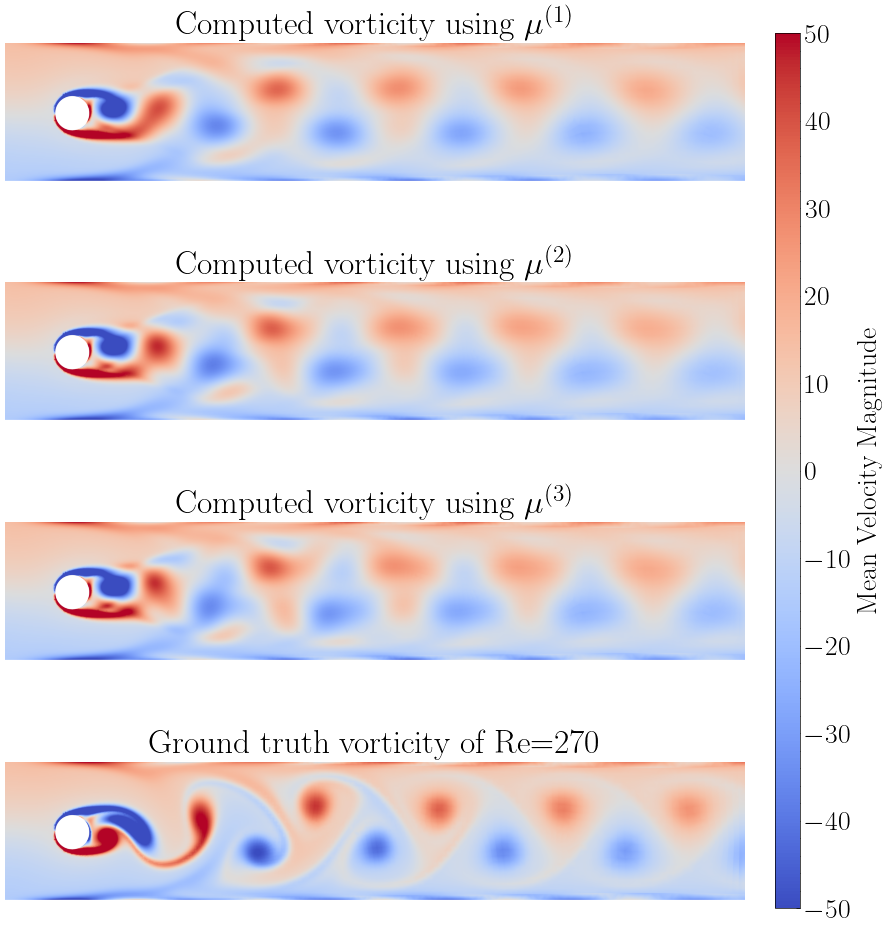

In [55]:
import matplotlib.pyplot as plt
import pyvista as pv
import h5py
import numpy as np

# Set up matplotlib figure
fig, axes = plt.subplots(4, 1, figsize=(10, 10))

with h5py.File(s_rec_full_file, "r") as s_rec_file:
    for i, index in enumerate(representatives):
        # Create a PyVista plotter for this subplot
        plotter = pv.Plotter(off_screen=True)
        
        # Load and process data
        s_rec_full = s_rec_file[f"combo_{index}"][:]
        vorticity_rep = compute_vorticity(u, omega, s_rec_full, T_end_index-1)
        
        # Set up the PyVista plot
        grid.point_data["Vorticity"] = vorticity_rep = compute_vorticity(u, omega, s_rec_full, T_end_index)
        grid.set_active_scalars("Vorticity")
        plotter.add_mesh(grid, show_edges=False, show_scalar_bar=False, clim=[-50, 50], lighting=False, cmap="coolwarm")
        plotter.view_xy()
        plotter.camera.tight()
        
        # Capture the PyVista plot as an image
        image = plotter.screenshot(transparent_background=True, scale=3)
        
        # Display the image in the matplotlib subplot
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(r"Computed vorticity using $\mu^{(" + f"{i+1}" + ")}$")
        
        # Clear the plotter to free up memory
        plotter.clear()

# Create a PyVista plotter for this subplot
plotter = pv.Plotter(off_screen=True)
# Set up the PyVista plot
grid.point_data["Vorticity"] = compute_vorticity(u, omega, X_all_test, T_end_index-1)
grid.set_active_scalars("Vorticity")
plotter.add_mesh(grid, show_edges=False, show_scalar_bar=False, clim=[-50, 50], lighting=False, cmap="coolwarm")
plotter.view_xy()
plotter.camera.tight()

# Capture the PyVista plot as an image
image = plotter.screenshot(transparent_background=True, scale=3)

# Display the image in the matplotlib subplot
axes[-1].imshow(image)
axes[-1].axis('off')  # Turn off axis
axes[-1].set_title(f"Ground truth vorticity of Re={test_Re}")

plotter.clear()

cax = fig.add_axes([0.8, 0.05, 0.025, 0.875], aspect="auto")
cbar = plt.colorbar(ScalarMappable(cmap="coolwarm", norm=Normalize(vmin=-50, vmax=50)),
                            cax=cax, orientation="vertical")
tick_locator = ticker.MaxNLocator(nbins=10)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label("Mean Velocity Magnitude")

plt.tight_layout(rect=[0, 0, 0.8, 1])
# plt.suptitle(f"Reconstructed Vorticity at t = {T_end_train}s")
# plt.savefig("vorticity_s_rec_full_operator_compare.png", dpi=300, bbox_inches='tight')
plt.savefig("soln_comb_selected_operators_vorticity.pdf", bbox_inches='tight')
plt.show()